# Instalace a importy

Restart běhového prostředí po instalaci tsai!

In [1]:
!pip install tsai
!pip install scipy==1.5
!pip install numba==0.51.2
!pip install fastai2_extensions
!pip install bayesian-optimization

     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 2.5MB 18.4MB/s 
     |████████████████████████████████| 215kB 49.5MB/s 
     |████████████████████████████████| 102kB 14.2MB/s 
     |████████████████████████████████| 3.4MB 52.6MB/s 
     |████████████████████████████████| 27.4MB 1.2MB/s 
     |████████████████████████████████| 942kB 23.2MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 9.5MB 43.0MB/s 
     |████████████████████████████████| 5.7MB 37.3MB/s 
     |████████████████████████████████| 194kB 60.3MB/s 
     |████████████████████████████████| 22.3MB 1.2MB/s 
     |████████████████████████████████| 1.1MB 61.2MB/s 
     |████████████████████████████████| 686kB 62.7MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 25.3MB 1.2MB/s 
     |████████████████████████████████| 112kB 61.3MB/s 
     |████████████████████████████████| 12.8MB 55.

     |████████████████████████████████| 25.9MB 1.2MB/s 
ERROR: fastai 2.3.0 has requirement torch<1.8,>=1.7.0, but you'll have torch 1.8.1+cu101 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
     |████████████████████████████████| 3.1MB 2.9MB/s 
     |████████████████████████████████| 24.6MB 108kB/s 
ERROR: tsai 0.2.17 has requirement numba>=0.53.1, but you'll have numba 0.51.2 which is incompatible.
  Found existing installation: llvmlite 0.36.0
    Uninstalling llvmlite-0.36.0:
      Successfully uninstalled llvmlite-0.36.0
  Found existing installation: numba 0.53.1
    Uninstalling numba-0.53.1:
      Successfully uninstalled numba-0.53.1
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=b3b9d4407ff4082a11a13

In [1]:
import tsai
from tsai.all import *
from tsai.models.utils import *
from tsai.models.ResNet import *
from tsai.learner import *
import pandas as pd
import numpy as np
from pathlib import Path
import json
import math
from psutil import virtual_memory
from google.colab import drive
from sklearn.preprocessing import MultiLabelBinarizer
from bayes_opt import BayesianOptimization
from functools import lru_cache
import pickle
import gc

print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.0
fastcore   : 1.3.19
torch      : 1.8.1+cu101


Zvýšení RAM

In [2]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


Používaná grafická karta

In [3]:
!nvidia-smi

Thu Apr 15 19:16:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    35W / 250W |    257MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Konstanty

In [4]:
SAMPLING_RATE = 500
DOWNSAMPLE = 2
WINDOW_SIZE = (10 * SAMPLING_RATE) // DOWNSAMPLE
Y_COLS = ['diagnosis']
Y_LABELS = ['premature atrial beat', 'premature ventricular beat']
Y_LABEL = 'premature ventricular beat'
ALL_DIAGNOSIS = {
    'sinus rhythm', 
    'noisy ECG', 
    'tachycardia', 
    'myocardial infarction',
    'bradycardia', 
    'STT changes', 
    'atrial fibrillation', 
    'premature atrial beat',
    'premature ventricular beat',   # Of interest
    'left bundle brunch block', 
    '1st degree AV block',
    'right bundle brunch block', 
    'supraventricular rhythm',
    'ventricular stimulation', 
    'atrial flutter', 
    'atrial stimulation',
    'ventricular preexcitation',
    'atrial rhythm',
    '3rd degree AV block',
    '2nd degree AV block',
    'non-specific intraventricular block',
    'ventricular rhythm',
    'SA block',
    'ventricular trigeminy'
}

Y_TO_DROP = [
    #'sinus rhythm', 
    'noisy ECG', 
    'tachycardia', 
    'myocardial infarction',
    'bradycardia', 
    'STT changes', 
    'atrial fibrillation', 
    'premature atrial beat',
    #'premature ventricular beat',   # Of interest
    'left bundle brunch block', 
    '1st degree AV block',
    'right bundle brunch block', 
    'supraventricular rhythm',
    'ventricular stimulation', 
    'atrial flutter', 
    'atrial stimulation',
    'ventricular preexcitation',
    'atrial rhythm',
    '3rd degree AV block',
    '2nd degree AV block',
    'non-specific intraventricular block',
    'ventricular rhythm',
    'SA block',
    'ventricular trigeminy'
]

# Načtení dat

Načtení df po filtraci

In [5]:
drive.mount("/content/drive")
data_folder = Path('/content/drive/My Drive/DataDP')
raw_df = pd.read_pickle(data_folder / 'plain_df_all_filter1603.pkl') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Změna z float64 na float32

In [6]:
raw_df[list(set(raw_df.columns).difference(Y_COLS))] = raw_df[set(raw_df.columns).difference(Y_COLS)].astype('float32')

# Výběr signálů s pouze jednou diagnózou



In [7]:
def create_diagnosis2multi_class(Y_TO_DROP_):
    def diagnosis2multi_class(cell):
        if (len(cell) == 1) and ('sinus rhythm' not in Y_TO_DROP_) and ('sinus rhythm' in cell):  
            return 'sinus rhythm'
        
        cell = [x for x in cell if (x not in Y_TO_DROP_) and (x != 'sinus rhythm')]
        if len(cell) > 1:
            return None
        cell = cell if len(cell) > 0 else ['other']
        return cell[0]
    return diagnosis2multi_class

In [8]:
raw_df['single_diagnosis'] = raw_df.diagnosis.map(create_diagnosis2multi_class(Y_TO_DROP))

In [9]:
df = raw_df.dropna()

In [10]:
df.single_diagnosis.value_counts() // 2500

other                         4231
sinus rhythm                  2234
premature ventricular beat     412
Name: single_diagnosis, dtype: int64

# Úprava dat

## Rovnoměrné rozdělení dat do train/val/test množin

In [12]:
def assign_dataset(df_):
    len_ = len(df_)
    df_ = df_.index.to_frame()
    df_['dataset'] = 'train'
    df_.loc[df_.iloc[int(0.7*len_):int(0.85*len_)].index,'dataset'] = 'val'
    df_.loc[df_.iloc[int(0.85*len_):].index,'dataset'] = 'test'
    return df_

df_split = df.groupby(['id']).head(1).groupby('single_diagnosis').apply(assign_dataset)

ids = {type_: df_split[df_split.dataset == type_].id for type_ in ['train', 'val', 'test']}
display([len(df.loc[ids_])//2500 for ids_ in ids.values()])

[4812, 1032, 1033]

## Vytvoření x_df = signálů a y_df = labelů

In [13]:
def take_y(df_):
    return df_.head(len(df_) // WINDOW_SIZE)

y_df = df.groupby(['id']).apply(take_y).single_diagnosis
x_df = df.drop(columns=['diagnosis', 'single_diagnosis'])

## Normalizace dat
Jsou použity MEAN a STD trénovací množiny


In [14]:
MEAN = x_df.loc[ids['train']].mean()
STD = x_df.loc[ids['train']].std()
x_df = ((x_df - MEAN ) / STD)
display(x_df.describe())

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
count,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07,1.719250e+07
mean,-8.872548e-05,-8.646412e-05,1.306925e-05,-9.802420e-05,-6.124501e-05,-4.637168e-05,1.060157e-04,1.183325e-04,-5.146887e-05,1.736769e-05,4.802354e-05,-3.859490e-04
std,9.521932e-01,9.267251e-01,9.295527e-01,9.423512e-01,9.475088e-01,9.158306e-01,9.681528e-01,9.695033e-01,9.758767e-01,9.789804e-01,9.843115e-01,9.816973e-01
min,-9.776588e+01,-7.773266e+01,-7.250401e+01,-9.136669e+01,-8.475625e+01,-8.732069e+01,-6.231284e+01,-5.901300e+01,-5.592271e+01,-6.425685e+01,-6.861039e+01,-5.691147e+01
25%,-1.140008e-01,-1.315672e-01,-7.907779e-02,-1.295631e-01,-1.014989e-01,-1.146249e-01,-4.792900e-02,-7.267669e-02,-1.024876e-01,-1.437246e-01,-1.487372e-01,-1.185612e-01
50%,-4.276926e-02,-3.886495e-02,7.251080e-03,-4.743844e-02,-2.734549e-02,-1.743177e-02,3.825401e-02,1.690238e-02,9.202496e-03,-2.561451e-02,-4.634828e-02,-4.244989e-02
75%,4.916678e-02,7.880975e-02,9.586265e-02,6.253893e-02,5.407203e-02,9.437832e-02,1.176337e-01,1.270303e-01,1.550175e-01,1.251899e-01,7.997983e-02,5.287977e-02
max,9.106999e+01,7.872922e+01,6.417405e+01,8.821186e+01,9.129800e+01,6.634133e+01,6.034406e+01,6.575033e+01,7.498516e+01,5.225375e+01,5.484349e+01,6.213913e+01


# Over-sampling

In [15]:
def df2np(df_):
    num = len(df_) // WINDOW_SIZE
    shape = num, min(len(df_), WINDOW_SIZE), len(df_.columns)
    return df_.to_numpy().reshape(shape)

def create_datasets(x_df_, y_df_, ids_, max_extra_=0, max_duplicate_=2):
    datasets = {'x': {}, 'y': {}}

    for type_, id_ in ids_.items():
        x_arr = df2np(x_df_.loc[id_])
        y_arr = y_df_.loc[id_]
        display(y_arr.value_counts())
        print()
        
        print(f'create_datasets | {type_} y_arr minimum: {y_arr.value_counts().min()}')
        NORM_TO = y_arr.value_counts().min() * max_duplicate_
        MAX_TO = y_arr.value_counts().min() * (max_extra_ + max_duplicate_)
        y_res, x_res = [], []
        for diag in y_df_.unique():   # na diagnózu
            index = y_arr == diag
            x_res.append(x_arr[index][:MAX_TO])
            print(f'{diag} {len(x_res[-1])}')
            multiply = math.ceil(NORM_TO / len(x_res[-1]))
            x_res[-1] = (np.repeat(x_res[-1], multiply, axis=0))
            x_res[-1] = x_res[-1][:MAX_TO] 
            y_res.append(np.repeat(diag, len(x_res[-1])))
            
        datasets['x'][type_] = np.concatenate(x_res)
        datasets['y'][type_] = np.concatenate(y_res)
        print(datasets['x'][type_].shape, np.concatenate(y_res).shape)
    return datasets

datasets = create_datasets(x_df, y_df, ids)

other                         2961
sinus rhythm                  1563
premature ventricular beat     288
Name: single_diagnosis, dtype: int64


create_datasets | train y_arr minimum: 288
other 576
sinus rhythm 576
premature ventricular beat 288
(1728, 2500, 12) (1728,)


other                         635
sinus rhythm                  335
premature ventricular beat     62
Name: single_diagnosis, dtype: int64


create_datasets | val y_arr minimum: 62
other 124
sinus rhythm 124
premature ventricular beat 62
(372, 2500, 12) (372,)


other                         635
sinus rhythm                  336
premature ventricular beat     62
Name: single_diagnosis, dtype: int64


create_datasets | test y_arr minimum: 62
other 124
sinus rhythm 124
premature ventricular beat 62
(372, 2500, 12) (372,)


# Dočasné uložení pro rychlejší práci v další části kódu

In [16]:
pickle.dump(datasets, open(data_folder / 'datasets.pkl', 'wb'))

In [17]:
datasets = pickle.load(open(data_folder / 'datasets.pkl', 'rb'))

# One-hot enkódování
Pro orientaci v datech (raw_df) a snadnější výběr tříd ke klasifikaci

In [18]:
mlb = MultiLabelBinarizer(sparse_output=True)

multilabel_y = raw_df.groupby(['id']).head(1).diagnosis
multilabel_y = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(multilabel_y),
                index=multilabel_y.index,
                columns=mlb.classes_)

In [19]:
multilabel_y.sum().sort_values()

ventricular trigeminy                     1
SA block                                  1
ventricular rhythm                        2
non-specific intraventricular block       2
2nd degree AV block                       6
3rd degree AV block                       6
atrial rhythm                             8
ventricular preexcitation                10
atrial stimulation                       15
atrial flutter                           44
ventricular stimulation                  96
supraventricular rhythm                 179
right bundle brunch block               179
1st degree AV block                     258
left bundle brunch block                262
premature ventricular beat              412
premature atrial beat                   418
atrial fibrillation                     586
STT changes                             669
bradycardia                             714
myocardial infarction                   771
tachycardia                            1045
noisy ECG                       

In [20]:
multilabel_y.drop(columns=Y_TO_DROP).sum(axis=1).value_counts()

1    5782
0     802
2     293
dtype: int64

In [21]:
multilabel_y.sum().sort_values(ascending=False).index

Index(['sinus rhythm', 'noisy ECG', 'tachycardia', 'myocardial infarction',
       'bradycardia', 'STT changes', 'atrial fibrillation',
       'premature atrial beat', 'premature ventricular beat',
       'left bundle brunch block', '1st degree AV block',
       'right bundle brunch block', 'supraventricular rhythm',
       'ventricular stimulation', 'atrial flutter', 'atrial stimulation',
       'ventricular preexcitation', 'atrial rhythm', '3rd degree AV block',
       '2nd degree AV block', 'non-specific intraventricular block',
       'ventricular rhythm', 'SA block', 'ventricular trigeminy'],
      dtype='object')

# Klasifikace

## Příprava dat


In [22]:
X, y, splits = combine_split_data([np.swapaxes(datasets['x']['train'], 1, 2),
                                   np.swapaxes(datasets['x']['val'], 1, 2),], 
                                  [datasets['y']['train'], 
                                   datasets['y']['val']])
X.shape, y.shape

((2100, 12, 2500), (2100,))

### Matice záměn - české popisky

In [23]:
class Interpretation(): #fastai
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        store_attr("dl,inputs,preds,targs,decoded,losses")

    @classmethod
    def from_learner(cls, learn, ds_idx=1, dl=None, act=None):
        "Construct interpretation object from a learner"
        if dl is None: dl = learn.dls[ds_idx]
        return cls(dl, *learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None))

    def top_losses(self, k=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, **kwargs):
        losses,idx = self.top_losses(k, largest)
        if not isinstance(self.inputs, tuple): self.inputs = (self.inputs,)
        if isinstance(self.inputs[0], Tensor): inps = tuple(o[idx] for o in self.inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in self.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

# Cell
class ClassificationInterpretation(Interpretation):
    "Interpretation methods for classification models."

    def __init__(self, dl, inputs, preds, targs, decoded, losses):
        super().__init__(dl, inputs, preds, targs, decoded, losses)
        self.vocab = self.dl.vocab
        if is_listy(self.vocab): self.vocab = self.vocab[-1]

    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`."
        x = torch.arange(0, len(self.vocab))
        d,t = flatten_check(self.decoded, self.targs)
        cm = ((d==x[:,None]) & (t==x[:,None,None])).long().sum(2)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize=False, title='Matice záměn', cmap="Blues", norm_dec=2,
                              plot_txt=True, **kwargs):
        "Plot the confusion matrix, with `title` and using `cmap`."
        cm = self.confusion_matrix()
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(len(self.vocab))
        plt.xticks(tick_marks, self.vocab, rotation=90)
        plt.yticks(tick_marks, self.vocab, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        ax = fig.gca()
        ax.set_ylim(len(self.vocab)-.5,-.5)

        plt.tight_layout()
        plt.ylabel('Skutečnost')
        plt.xlabel('Predikce')
        plt.grid(False)

def compute_f1(learn_, y_df_, y_label_):
    interp = ClassificationInterpretation.from_learner(learn_)
    conf_matrix = interp.confusion_matrix()
    res_ = [i for i, name_ in enumerate(sorted(y_df_.unique())) if name_ == y_label_]
    if len(res_) != 1:
        return -1.0
    CHOSEN_LABEL_ID = res_[0]
    correct = conf_matrix[CHOSEN_LABEL_ID, CHOSEN_LABEL_ID]
    recall = correct / conf_matrix[CHOSEN_LABEL_ID].sum()
    precision = correct / conf_matrix[:, CHOSEN_LABEL_ID].sum()
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1

## Trénování

In [24]:
mixup = MixUp1d(0.4)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], 
                                 batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=[accuracy, error_rate], cbs = mixup)
#learn.lr_find(suggestions=True)

'Iteration    0'

lr=0.003


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.028651,1.794831,0.513441,0.486559,00:04
1,1.011839,0.909485,0.569892,0.430108,00:03
2,0.984965,0.886093,0.599462,0.400538,00:03


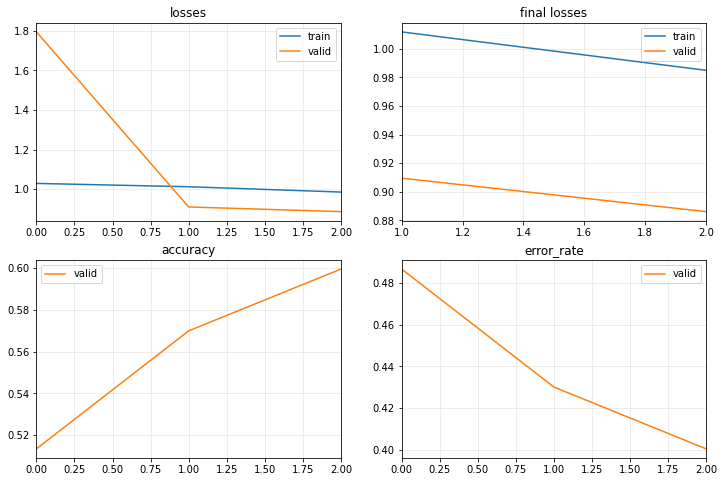

'Iteration    1'

lr=0.003


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.993130,0.960657,0.543011,0.456989,00:03
1,0.971771,0.874602,0.620968,0.379032,00:03
2,0.945328,0.866822,0.610215,0.389785,00:03


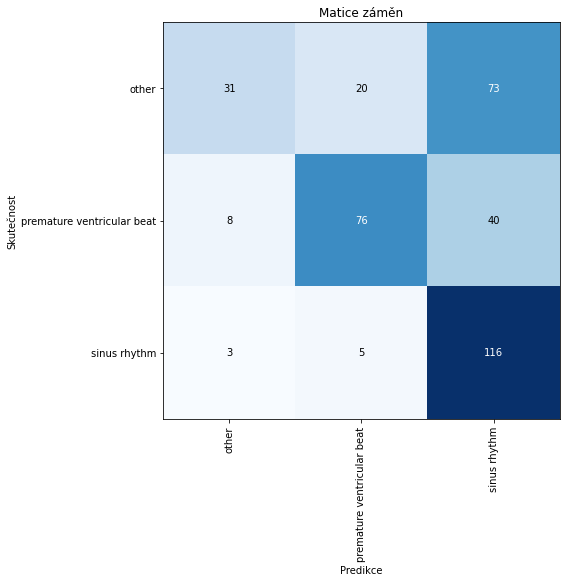

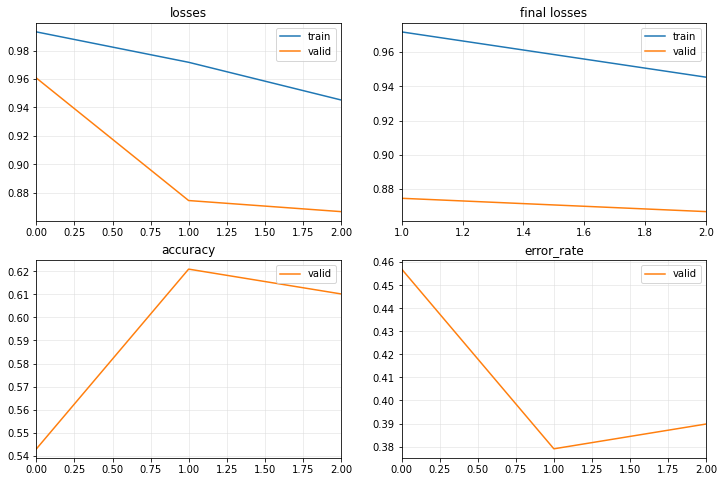

'Iteration    2'

lr=0.003


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.948170,1.084716,0.456989,0.543011,00:03
1,0.939453,0.831043,0.607527,0.392473,00:03
2,0.912825,0.834320,0.626344,0.373656,00:03


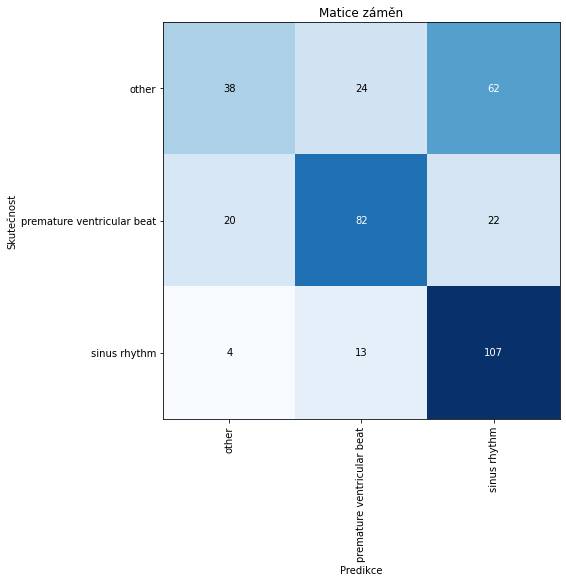

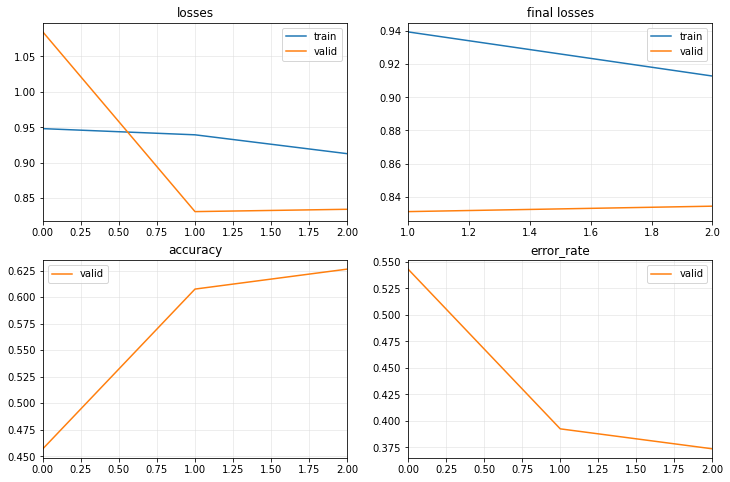

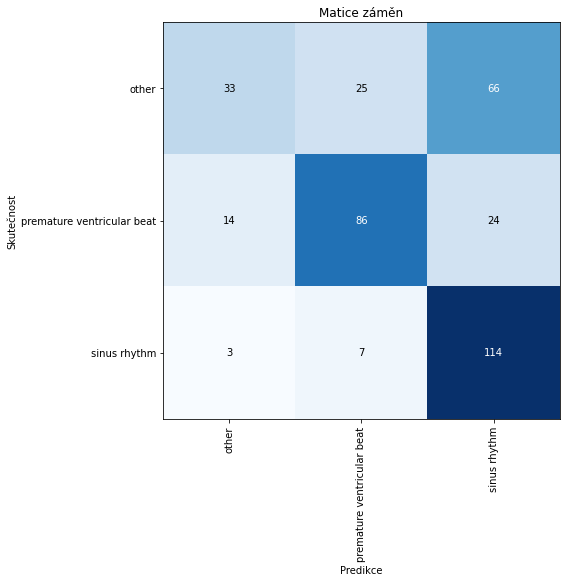

In [25]:
for i in range(3):
    display(f'Iteration {i:4}')
    lr_max=3e-3
    print(f'lr={lr_max}')
    learn.fit_one_cycle(3, lr_max=lr_max)
    learn.plot_metrics()
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(figsize=(8, 8))

## Další vizualizace výsledků

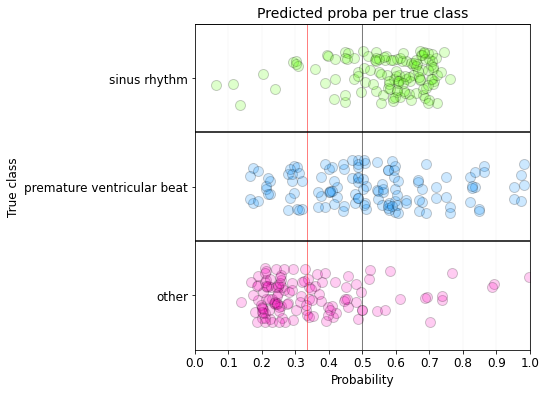

In [26]:
learn.show_probas()

## Různé modely

In [ ]:
bs = 64
print(X.shape)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
         #(LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
         #(LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}), 
         (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy, cbs=mixup)
    start = time.time()
    learn.fit_one_cycle(30, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, total_params(model)[0], vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

# Evaluace hyperparametrů - manuální




In [27]:
@lru_cache(maxsize=5)   # caches the last maxsize computations, works only if this cell is not rerun
def create_df(y_to_drop_):
    print(f'Recomputing create_df {y_to_drop_}')
    # Předzpracování
    raw_df['single_diagnosis'] = raw_df.diagnosis.map(create_diagnosis2multi_class(y_to_drop_))
    df = raw_df.dropna()
    df_split = df.groupby(['id']).head(1).groupby('single_diagnosis').apply(assign_dataset)
    ids = {type_: df_split[df_split.dataset == type_].id for type_ in ['train', 'val', 'test']}
    y_df = df.groupby(['id']).apply(take_y).single_diagnosis
    x_df = df.drop(columns=['diagnosis', 'single_diagnosis'])

    # Normalizace
    MEAN = x_df.loc[ids['train']].mean()
    STD = x_df.loc[ids['train']].std()
    x_df = ((x_df - MEAN ) / STD)
    return x_df, y_df, ids

Classifying on {'bradycardia', 'STT changes', 'sinus rhythm', 'myocardial infarction', 'premature ventricular beat', 'tachycardia', 'noisy ECG', 'atrial fibrillation', 'premature atrial beat'} + the rest
Recomputing create_df ('1st degree AV block', 'supraventricular rhythm', 'atrial stimulation', 'atrial flutter', 'right bundle brunch block', 'ventricular trigeminy', 'ventricular stimulation', 'non-specific intraventricular block', 'ventricular rhythm', 'atrial rhythm', 'left bundle brunch block', '3rd degree AV block', 'ventricular preexcitation', '2nd degree AV block', 'SA block')


sinus rhythm                  1563
noisy ECG                      669
tachycardia                    305
bradycardia                    294
atrial fibrillation            174
other                          158
myocardial infarction          128
premature atrial beat          100
premature ventricular beat      77
STT changes                     66
Name: single_diagnosis, dtype: int64


create_datasets | train y_arr minimum: 66
noisy ECG 198
sinus rhythm 198
tachycardia 198
atrial fibrillation 174
bradycardia 198
premature ventricular beat 77
myocardial infarction 128
premature atrial beat 100
other 158
STT changes 66
(1980, 2500, 12) (1980,)


sinus rhythm                  335
noisy ECG                     143
tachycardia                    66
bradycardia                    63
atrial fibrillation            37
other                          34
myocardial infarction          28
premature atrial beat          22
premature ventricular beat     16
STT changes                    14
Name: single_diagnosis, dtype: int64


create_datasets | val y_arr minimum: 14
noisy ECG 42
sinus rhythm 42
tachycardia 42
atrial fibrillation 37
bradycardia 42
premature ventricular beat 16
myocardial infarction 28
premature atrial beat 22
other 34
STT changes 14
(420, 2500, 12) (420,)


sinus rhythm                  336
noisy ECG                     144
tachycardia                    66
bradycardia                    63
atrial fibrillation            38
other                          34
myocardial infarction          28
premature atrial beat          22
premature ventricular beat     17
STT changes                    15
Name: single_diagnosis, dtype: int64


create_datasets | test y_arr minimum: 15
noisy ECG 45
sinus rhythm 45
tachycardia 45
atrial fibrillation 38
bradycardia 45
premature ventricular beat 17
myocardial infarction 28
premature atrial beat 22
other 34
STT changes 15
(450, 2500, 12) (450,)


'Iteration    0'

epoch,train_loss,valid_loss,accuracy,time
0,2.167544,2.464329,0.290476,00:04
1,2.043764,1.948867,0.347619,00:04


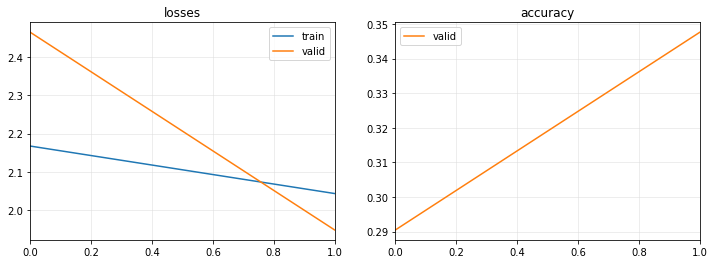

premature ventricular beat F1 score == 0.2353
atrial fibrillation F1 score == 0.1404


'Iteration    1'

epoch,train_loss,valid_loss,accuracy,time
0,1.963007,2.974521,0.190476,00:04
1,1.918142,1.917535,0.283333,00:04


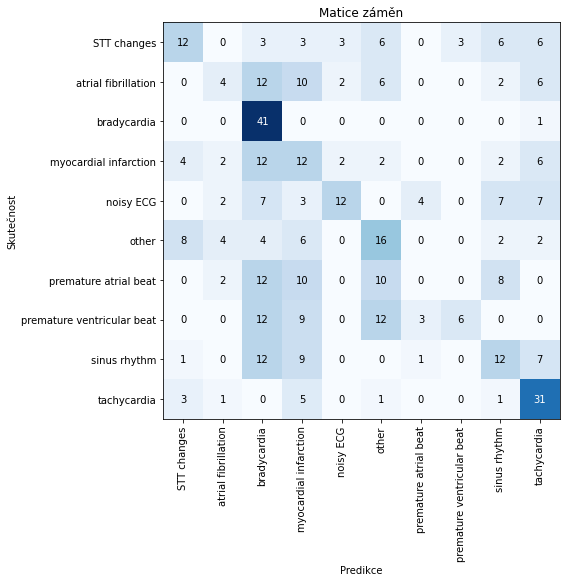

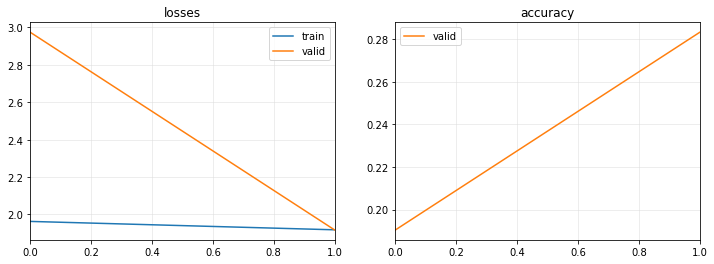

premature ventricular beat F1 score == 0.1176
atrial fibrillation F1 score == 0.08696
Classifying on {'bradycardia', 'STT changes', 'sinus rhythm', 'myocardial infarction', 'premature ventricular beat', 'tachycardia', 'noisy ECG', 'atrial fibrillation', 'premature atrial beat'} + the rest


sinus rhythm                  1563
noisy ECG                      669
tachycardia                    305
bradycardia                    294
atrial fibrillation            174
other                          158
myocardial infarction          128
premature atrial beat          100
premature ventricular beat      77
STT changes                     66
Name: single_diagnosis, dtype: int64


create_datasets | train y_arr minimum: 66
noisy ECG 198
sinus rhythm 198
tachycardia 198
atrial fibrillation 174
bradycardia 198
premature ventricular beat 77
myocardial infarction 128
premature atrial beat 100
other 158
STT changes 66
(1980, 2500, 12) (1980,)


sinus rhythm                  335
noisy ECG                     143
tachycardia                    66
bradycardia                    63
atrial fibrillation            37
other                          34
myocardial infarction          28
premature atrial beat          22
premature ventricular beat     16
STT changes                    14
Name: single_diagnosis, dtype: int64


create_datasets | val y_arr minimum: 14
noisy ECG 42
sinus rhythm 42
tachycardia 42
atrial fibrillation 37
bradycardia 42
premature ventricular beat 16
myocardial infarction 28
premature atrial beat 22
other 34
STT changes 14
(420, 2500, 12) (420,)


sinus rhythm                  336
noisy ECG                     144
tachycardia                    66
bradycardia                    63
atrial fibrillation            38
other                          34
myocardial infarction          28
premature atrial beat          22
premature ventricular beat     17
STT changes                    15
Name: single_diagnosis, dtype: int64


create_datasets | test y_arr minimum: 15
noisy ECG 45
sinus rhythm 45
tachycardia 45
atrial fibrillation 38
bradycardia 45
premature ventricular beat 17
myocardial infarction 28
premature atrial beat 22
other 34
STT changes 15
(450, 2500, 12) (450,)


'Iteration    0'

epoch,train_loss,valid_loss,accuracy,time
0,2.159780,1.945723,0.280952,00:04
1,2.042566,1.951778,0.328571,00:04


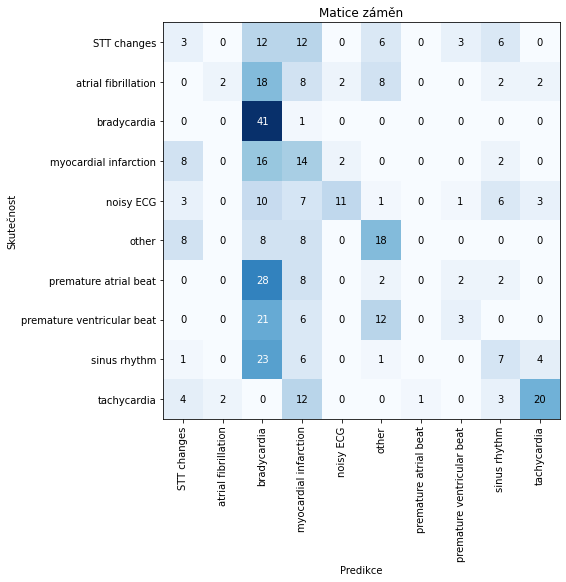

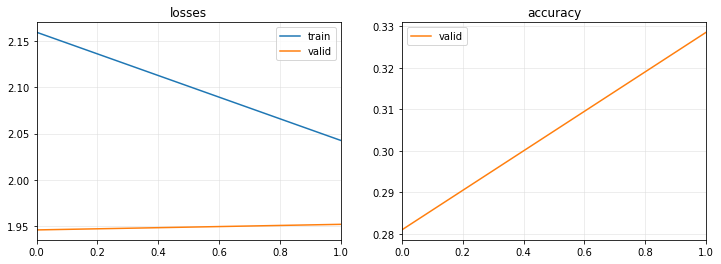

premature ventricular beat F1 score == 0.1154
atrial fibrillation F1 score == nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


'Iteration    1'

epoch,train_loss,valid_loss,accuracy,time
0,1.951429,2.268126,0.245238,00:04
1,1.909114,1.926196,0.361905,00:04


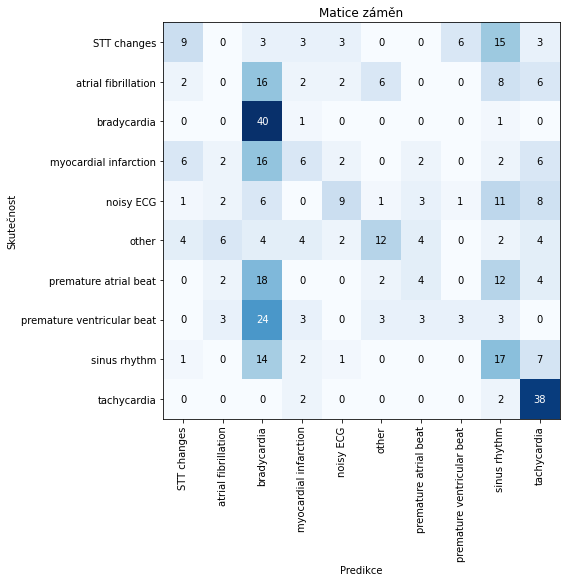

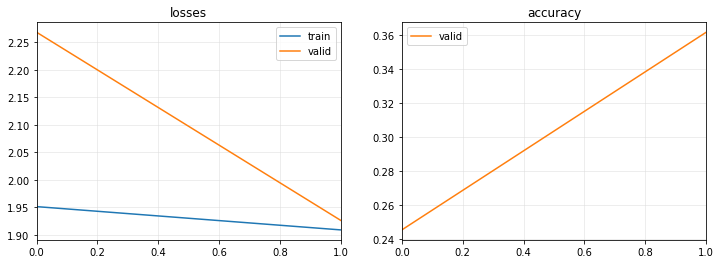

premature ventricular beat F1 score == 0.338
atrial fibrillation F1 score == 0.06061


0.2866611433305717

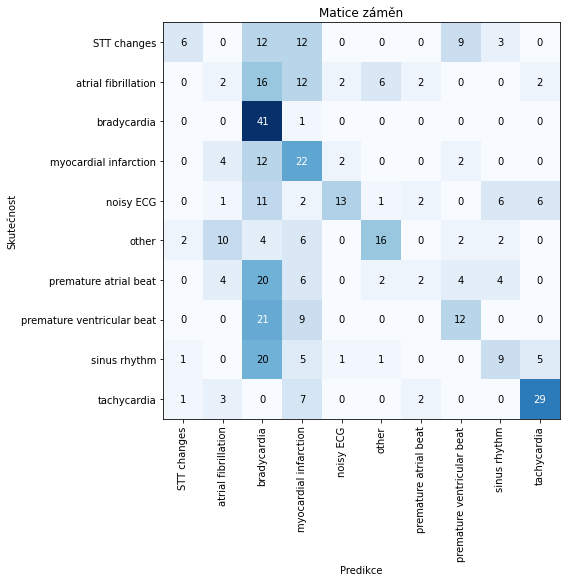

In [28]:
# %%time
import copy

def logit(text):
    log_file = data_folder / 'log.log'
    with open(log_file, 'a') as wf:
        wf.write(text)


def eval_hyperparams(y_to_drop_, y_labels_, max_extra_, max_duplicate_, mixup_alpha_, 
                     num_of_cycles_, cycle_len_, bs_, max_lr_, return_model=False):
    """
    Param ranges:
        y_to_drop_: list of cols
        max_extra_: 0<
        max_duplicate_: 0<
        mixup_alpha_: 0.0--0.6
        num_of_cycles_: 1<
        cycle_len_: 1<
        bs_: 8--256
        max_lr_: 1e-4--5e-3
    """
    print(f'Classifying on {ALL_DIAGNOSIS.difference(y_to_drop_)} + the rest')
    # Ošetření vstupů
    y_to_drop_, max_extra_, max_duplicate_, mixup_alpha_, num_of_cycles_, cycle_len_, bs_ = (
        y_to_drop_, int(max_extra_), int(max_duplicate_), mixup_alpha_, int(num_of_cycles_), int(cycle_len_), int(bs_)
    )

    x_df, y_df, ids = create_df(tuple(set(y_to_drop_)))

    # Vytvoření datasetu
    datasets = create_datasets(x_df, y_df, ids, max_extra_, max_duplicate_)
    X, y, splits = combine_split_data([np.swapaxes(datasets['x']['train'], 1, 2),
                                    np.swapaxes(datasets['x']['val'], 1, 2),], 
                                    [datasets['y']['train'], 
                                    datasets['y']['val']])
    # Model
    mixup = MixUp1d(mixup_alpha_)
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs_, 128], 
                                    # batch_tfms=[TSStandardize()], 
                                     num_workers=0)
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=[accuracy, ], cbs=mixup)

    max_F1 = 0.0
    best_model = None

    # Train
    for i in range(num_of_cycles_):
        display(f'Iteration {i:4}')
        lr_max=3e-3
        learn.fit_one_cycle(cycle_len_, lr_max=lr_max)
        learn.plot_metrics()
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix(figsize=(8, 8))
        
        # Spočtení F1
        F1s = [compute_f1(learn, y_df, y_label_) for y_label_ in y_labels_]
        print('\n'.join([f'{y_label_} F1 score == {F1:2.4}' for y_label_, F1 in zip(y_labels_, F1s)]))
        max_F1 = max(F1s[0], max_F1)
        if return_model and max_F1 == F1s[0]:
            best_model = copy.deepcopy(learn)
    logit(f'{max_F1:2.4f}|')
    
    if return_model:
        return best_model
    return max_F1

def generate_eval_hyperparams(y_to_drop_, y_label_, k_avg=1):
    """
    y_labels_: the first will be used to compute F1, the rest is just to see results
    k_avg: average the validation over k_avg runs
    """
    def wrapper_eval_hyperparams(*args, **kwargs):
        logit(f'\n{kwargs}\n')
        res_ = np.array([eval_hyperparams(y_to_drop_, y_label_, *args, **kwargs) 
                         for _ in range(k_avg)])
        logit(f'|{res_.mean():2.4f}\n')
        return res_.mean()
    return wrapper_eval_hyperparams

Y_LABELS = ['premature ventricular beat', 'atrial fibrillation']

Y_TO_DROP_ = [
    'sinus rhythm', 
    'noisy ECG', 
    'tachycardia', 
    'myocardial infarction',
    'bradycardia', 
    'STT changes', 
    'atrial fibrillation', 
    'premature atrial beat',
#     'premature ventricular beat',   # Of interest
    'left bundle brunch block', 
    '1st degree AV block',
    'right bundle brunch block', 
    'supraventricular rhythm',
    'ventricular stimulation', 
    'atrial flutter', 
    'atrial stimulation',
    'ventricular preexcitation',
    'atrial rhythm',
    '3rd degree AV block',
    '2nd degree AV block',
    'non-specific intraventricular block',
    'ventricular rhythm',
    'SA block',
    'ventricular trigeminy'
]
Y_TO_USE_ = [
    'sinus rhythm', 
    'noisy ECG', 
    'tachycardia', 
    'myocardial infarction',
    'bradycardia', 
    'STT changes', 
    'atrial fibrillation', 
    'premature atrial beat',
    'premature ventricular beat',   # Of interest
]


res = generate_eval_hyperparams(ALL_DIAGNOSIS.difference(Y_TO_USE_), Y_LABELS, 2)(max_extra_=0, max_duplicate_=3, 
                                                        mixup_alpha_=0.35, num_of_cycles_=2, 
                                                        cycle_len_=2, bs_=64, max_lr_=3e-3)
res

In [ ]:
del res

# CAM

Classifying on {'premature ventricular beat', 'sinus rhythm'} + the rest
Recomputing create_df ('bradycardia', 'supraventricular rhythm', 'atrial stimulation', 'STT changes', 'right bundle brunch block', 'myocardial infarction', 'ventricular stimulation', 'non-specific intraventricular block', 'left bundle brunch block', '3rd degree AV block', '2nd degree AV block', 'premature atrial beat', '1st degree AV block', 'atrial flutter', 'ventricular trigeminy', 'tachycardia', 'ventricular rhythm', 'atrial rhythm', 'noisy ECG', 'atrial fibrillation', 'ventricular preexcitation', 'SA block')


other                         2961
sinus rhythm                  1563
premature ventricular beat     288
Name: single_diagnosis, dtype: int64


create_datasets | train y_arr minimum: 288
other 864
sinus rhythm 864
premature ventricular beat 288
(2592, 2500, 12) (2592,)


other                         635
sinus rhythm                  335
premature ventricular beat     62
Name: single_diagnosis, dtype: int64


create_datasets | val y_arr minimum: 62
other 186
sinus rhythm 186
premature ventricular beat 62
(558, 2500, 12) (558,)


other                         635
sinus rhythm                  336
premature ventricular beat     62
Name: single_diagnosis, dtype: int64


create_datasets | test y_arr minimum: 62
other 186
sinus rhythm 186
premature ventricular beat 62
(558, 2500, 12) (558,)


'Iteration    0'

epoch,train_loss,valid_loss,accuracy,time
0,0.989865,1.029986,0.451613,00:06
1,0.986004,0.937950,0.569892,00:05
2,0.960673,1.104935,0.578853,00:05
3,0.926056,0.901771,0.602151,00:05
4,0.891913,0.852899,0.621864,00:05
5,0.862826,0.889248,0.550179,00:05
6,0.842922,0.838824,0.611111,00:05


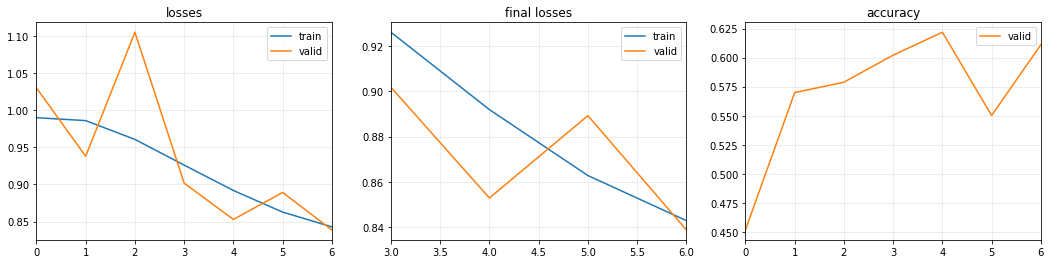

premature ventricular beat F1 score == 0.6835
atrial fibrillation F1 score == -1.0


'Iteration    1'

epoch,train_loss,valid_loss,accuracy,time
0,0.867770,0.876809,0.566308,00:05
1,0.919035,0.921676,0.525090,00:05
2,0.894978,0.967665,0.487455,00:05
3,0.871943,0.878668,0.571685,00:05
4,0.838133,0.816019,0.652330,00:05
5,0.805832,0.802232,0.612903,00:05
6,0.789511,0.787469,0.654122,00:05


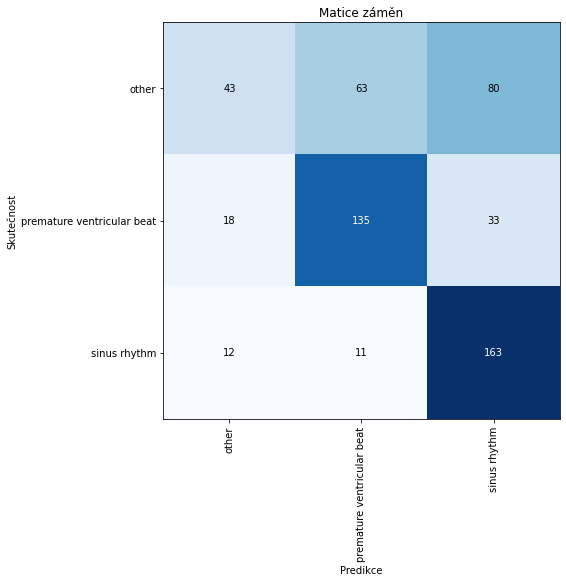

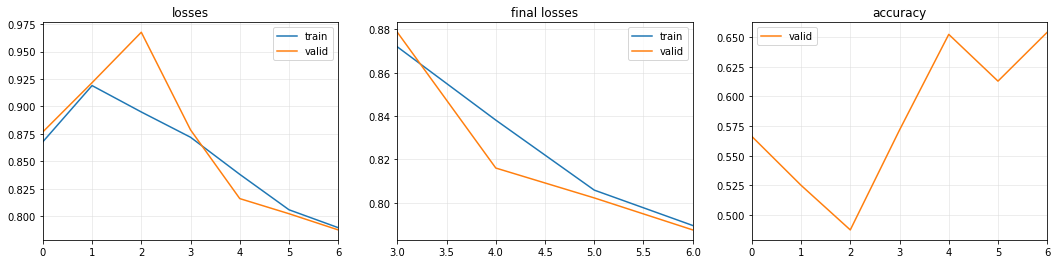

premature ventricular beat F1 score == 0.7437
atrial fibrillation F1 score == -1.0


'Iteration    2'

epoch,train_loss,valid_loss,accuracy,time
0,0.795635,0.910025,0.598566,00:06
1,0.828948,0.813858,0.632616,00:06
2,0.846765,0.857956,0.621864,00:06
3,0.828270,0.902812,0.523297,00:06
4,0.800431,0.807870,0.625448,00:06
5,0.767880,0.771538,0.645161,00:05
6,0.742324,0.816615,0.625448,00:06


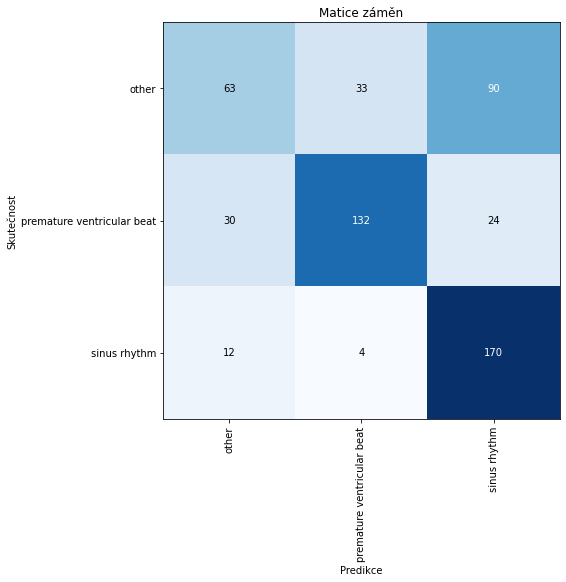

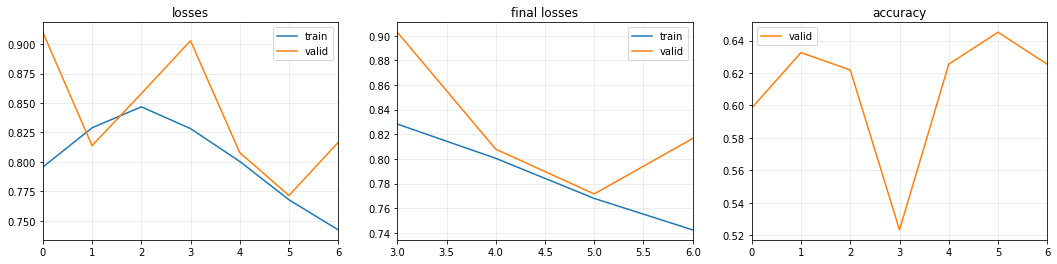

premature ventricular beat F1 score == 0.7167
atrial fibrillation F1 score == -1.0


'Iteration    3'

epoch,train_loss,valid_loss,accuracy,time
0,0.760942,0.827051,0.625448,00:06
1,0.824939,0.877502,0.650538,00:06
2,0.802744,0.763391,0.637993,00:06
3,0.781899,0.781915,0.620072,00:06
4,0.744968,0.832159,0.609319,00:06
5,0.720615,0.754950,0.652330,00:06
6,0.693164,0.780009,0.648746,00:06


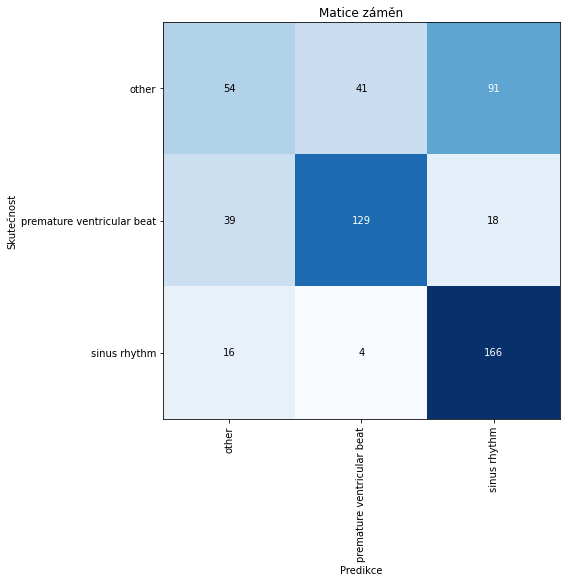

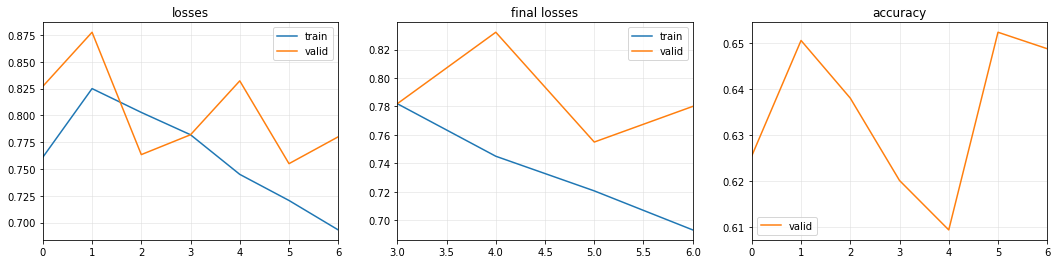

premature ventricular beat F1 score == 0.7172
atrial fibrillation F1 score == -1.0


'Iteration    4'

epoch,train_loss,valid_loss,accuracy,time
0,0.703602,0.793254,0.625448,00:06
1,0.752040,0.774921,0.663082,00:06
2,0.757579,0.835969,0.639785,00:06
3,0.741337,0.816983,0.607527,00:06
4,0.715828,0.775403,0.632616,00:06
5,0.660239,0.829639,0.605735,00:06
6,0.647357,0.787091,0.630824,00:06


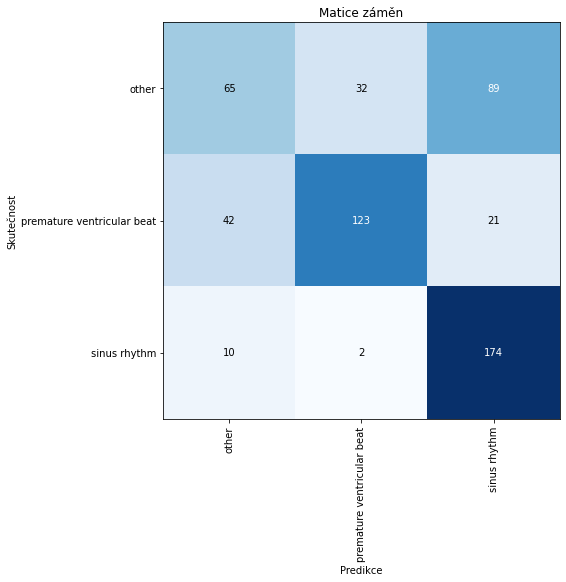

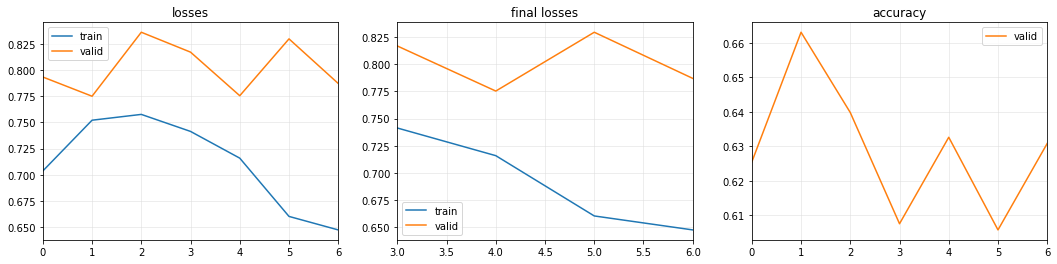

premature ventricular beat F1 score == 0.6465
atrial fibrillation F1 score == -1.0


'Iteration    5'

epoch,train_loss,valid_loss,accuracy,time
0,0.667597,0.785050,0.677419,00:06
1,0.716587,0.910923,0.548387,00:06
2,0.756734,0.908467,0.517921,00:06
3,0.709919,0.762841,0.632616,00:06
4,0.666110,0.669467,0.700717,00:06
5,0.646898,0.701412,0.702509,00:06
6,0.612642,0.732323,0.709677,00:06


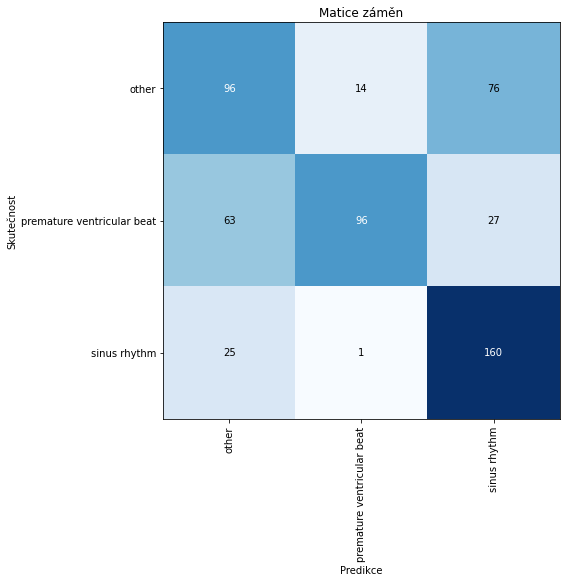

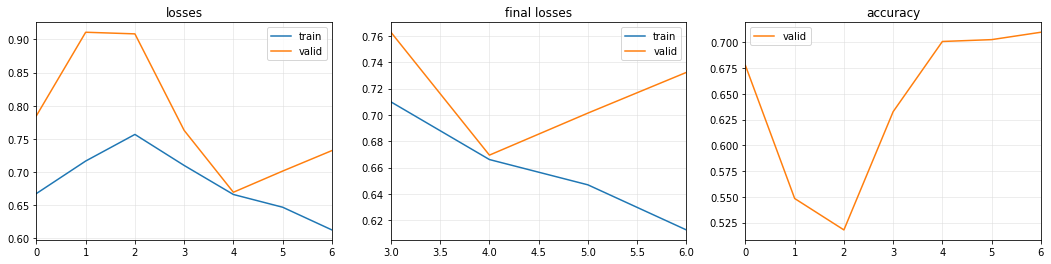

premature ventricular beat F1 score == 0.7317
atrial fibrillation F1 score == -1.0


'Iteration    6'

epoch,train_loss,valid_loss,accuracy,time
0,0.629797,0.767601,0.632616,00:06
1,0.741313,0.979534,0.546595,00:06
2,0.698665,0.702562,0.731183,00:06
3,0.693038,0.794985,0.650538,00:06
4,0.651135,0.761221,0.686380,00:06
5,0.617613,0.719807,0.693548,00:06
6,0.594375,0.689601,0.715054,00:06


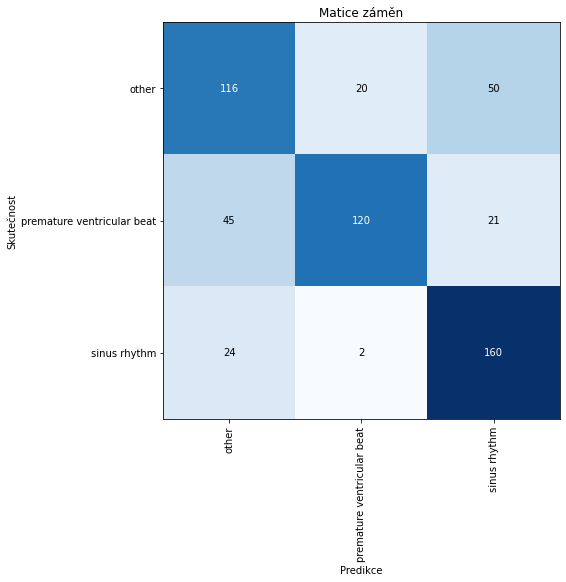

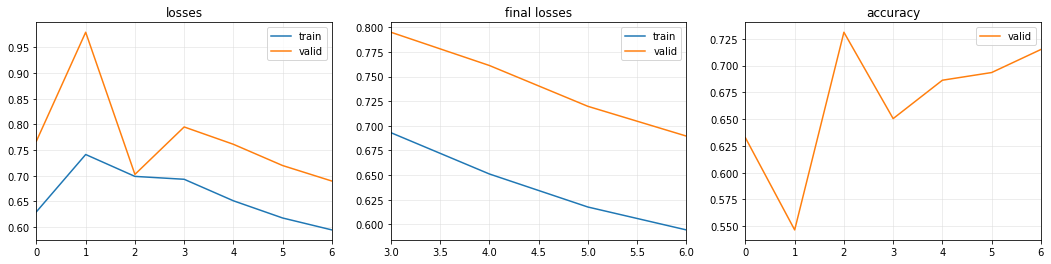

premature ventricular beat F1 score == 0.7407
atrial fibrillation F1 score == -1.0


'Iteration    7'

epoch,train_loss,valid_loss,accuracy,time
0,0.610134,0.724854,0.743728,00:06
1,0.657338,0.777936,0.655914,00:06
2,0.665823,0.957909,0.541219,00:06
3,0.635578,0.832527,0.616487,00:06
4,0.624657,0.728713,0.670251,00:06
5,0.582053,0.735816,0.670251,00:06
6,0.575696,0.766631,0.657706,00:06


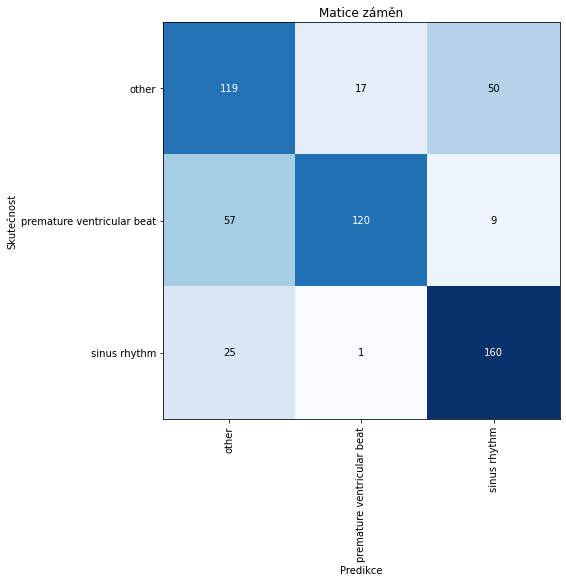

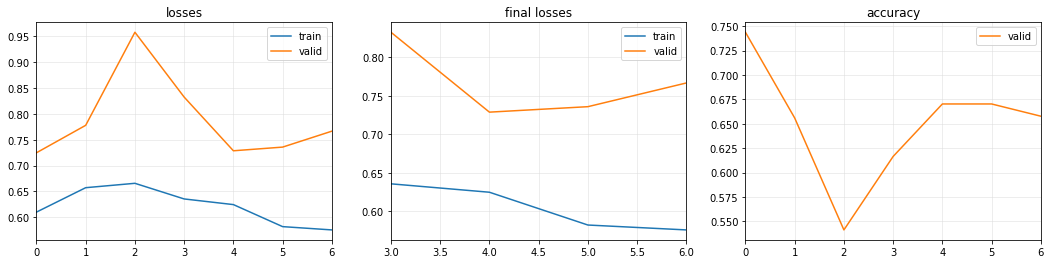

premature ventricular beat F1 score == 0.6242
atrial fibrillation F1 score == -1.0
CPU times: user 8min 34s, sys: 1min 46s, total: 10min 21s
Wall time: 6min 27s


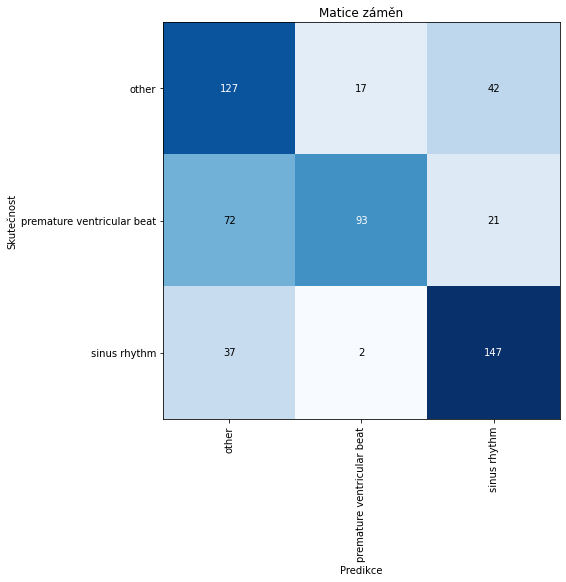

In [29]:
%%time
y_to_use_ = ['sinus rhythm', 'noisy ECG', 'tachycardia', 'myocardial infarction', 'bradycardia', 'STT changes', 'atrial fibrillation', 'premature atrial beat', 'premature ventricular beat']
y_to_use_ = ['sinus rhythm', 'premature ventricular beat']
kwargs = {'bs_': 32, 'cycle_len_': 7, 'max_duplicate_': 3, 'max_extra_': 0, 'max_lr_': 0.005, 'mixup_alpha_': 0.3, 'num_of_cycles_': 8}

model = eval_hyperparams(ALL_DIAGNOSIS.difference(y_to_use_), Y_LABELS, return_model=True, **kwargs)
model

In [31]:
np.argsort(y == 'premature ventricular beat')

array([   0,  937,  936, ..., 1473, 1461, 2099])

## CAM

Working on premature ventricular beat
{'other': 0.3129347860813141, 'premature ventricular beat': 0.12620027363300323, 'sinus rhythm': 0.5608649253845215}
Working on premature ventricular beat
{'other': 0.21967053413391113, 'premature ventricular beat': 0.3768369257450104, 'sinus rhythm': 0.4034925401210785}
Working on premature ventricular beat
{'other': 0.21121007204055786, 'premature ventricular beat': 0.659536600112915, 'sinus rhythm': 0.1292533576488495}
Working on premature ventricular beat
{'other': 0.2679826617240906, 'premature ventricular beat': 0.7099424600601196, 'sinus rhythm': 0.0220748633146286}
Working on premature ventricular beat
{'other': 0.14960330724716187, 'premature ventricular beat': 0.7004773616790771, 'sinus rhythm': 0.149919331073761}
Working on premature ventricular beat
{'other': 0.5884748101234436, 'premature ventricular beat': 0.3222006559371948, 'sinus rhythm': 0.08932459354400635}
Working on premature ventricular beat
{'other': 0.20243658125400543, 'pre

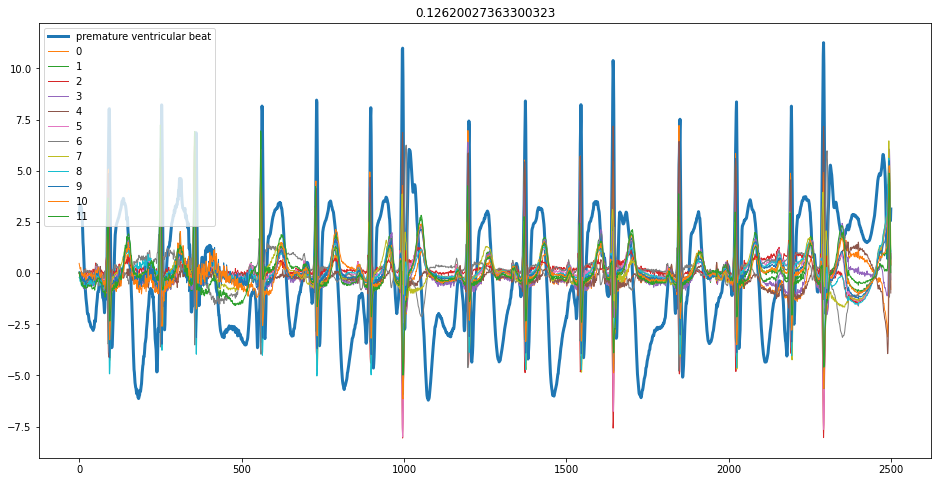

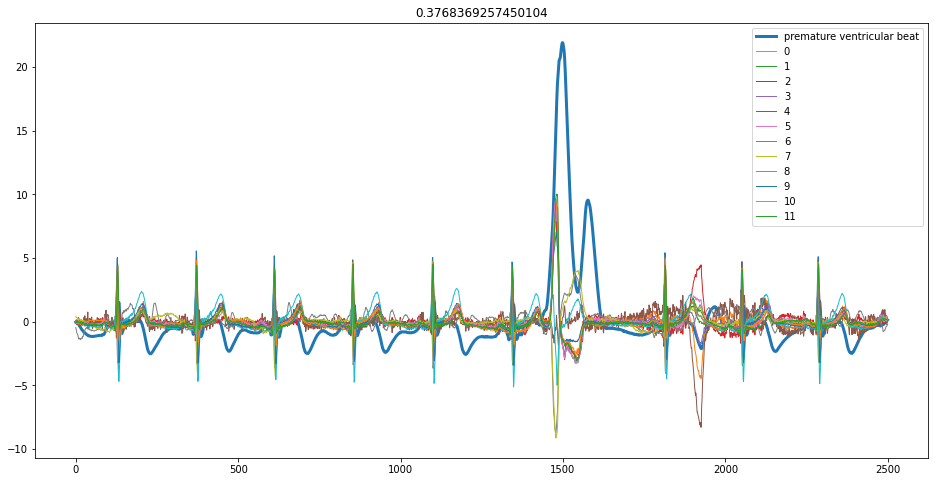

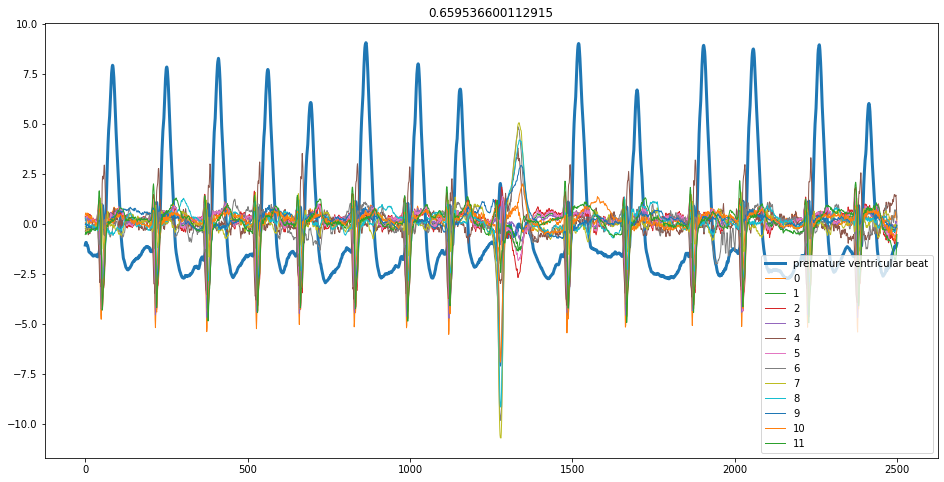

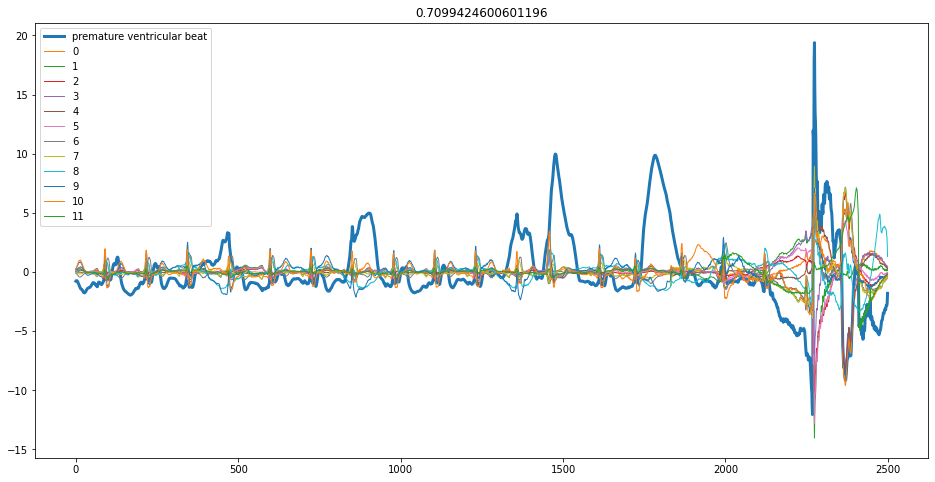

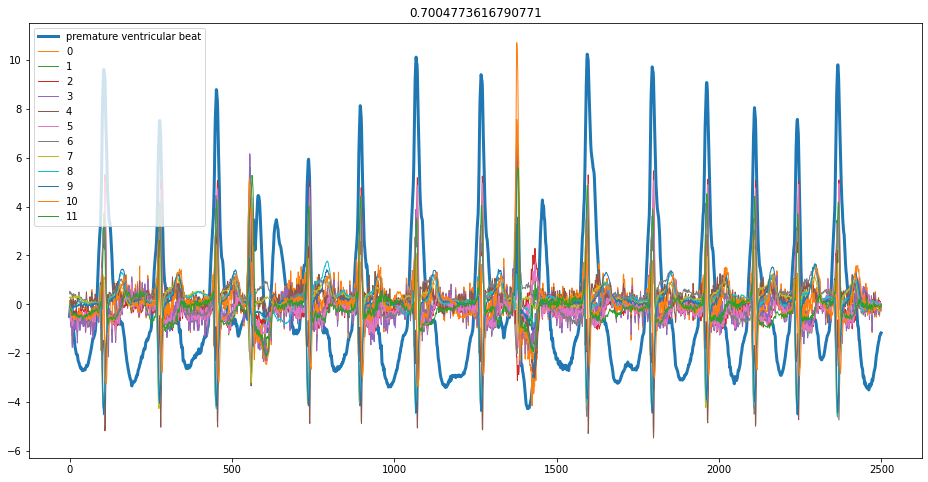

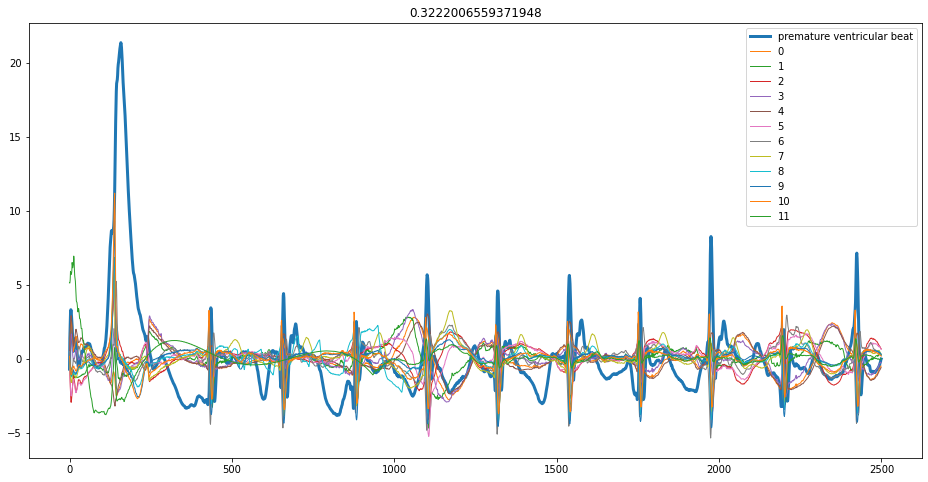

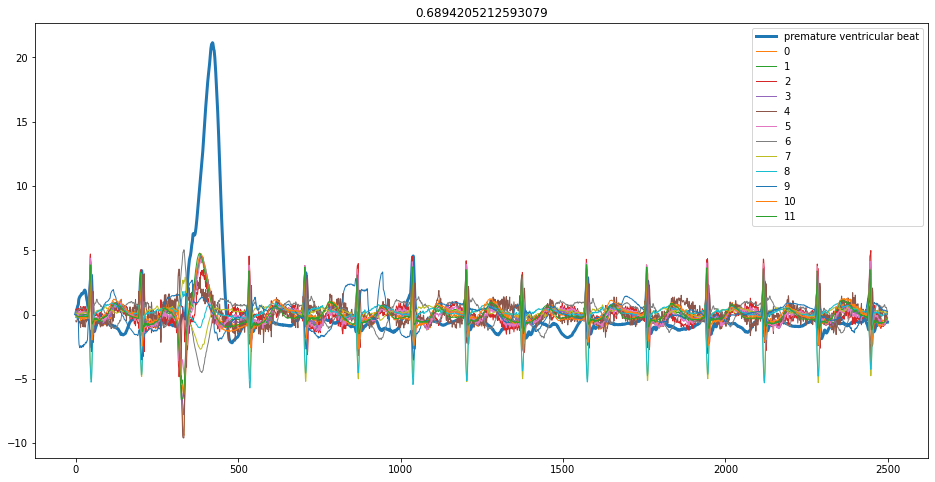

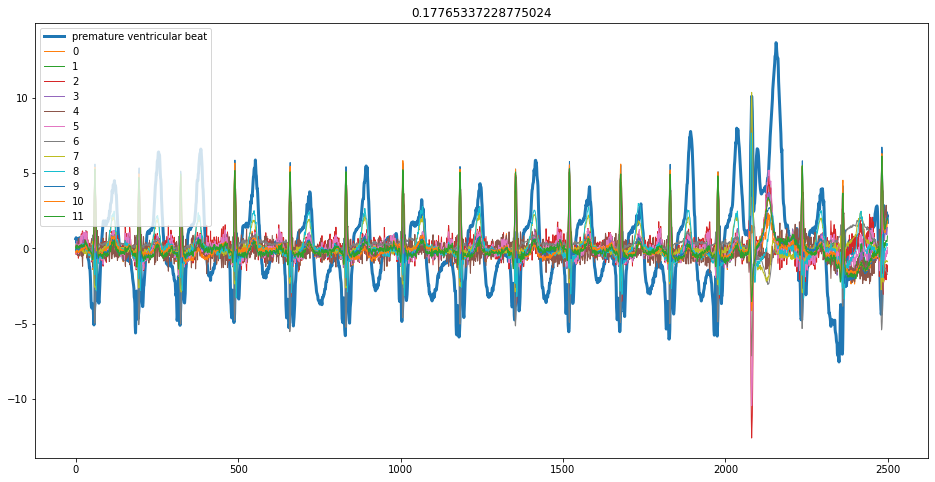

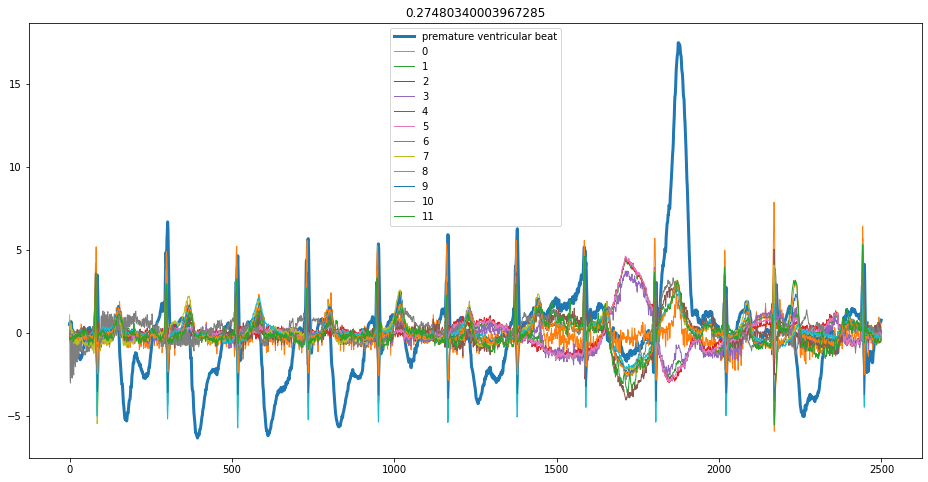

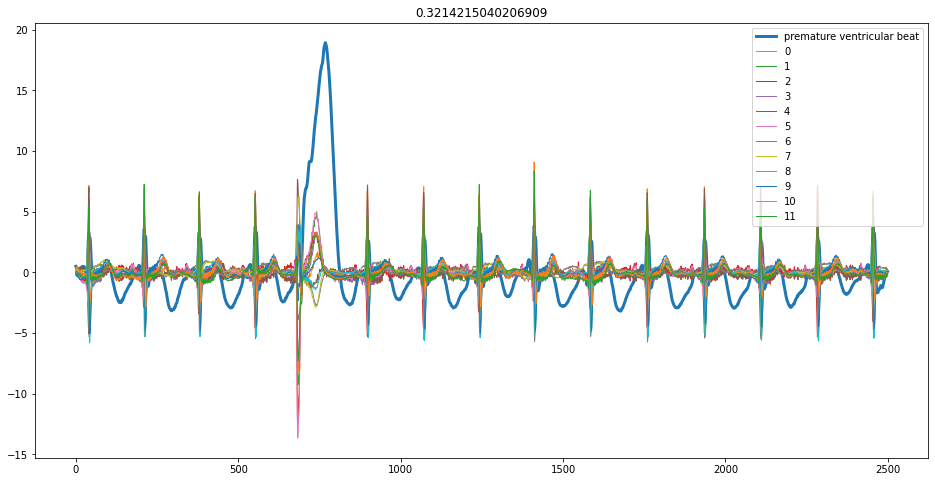

In [32]:
y_cls = sorted(set(y))

def get_id_CAM(id_=None, x_numpy=None):
    layer = dict(model.model.named_modules())['inceptionblock.act'] # výběr vrstvy
    if id_ is not None:
        x_numpy = X[id_:id_+1]
    x = torch.from_numpy(x_numpy).type(torch.cuda.FloatTensor) # dataset pro GPU použití
    print(f'Working on {y[id_]}')

    class Hook():
        def __init__(self, m):
            self.hook = m.register_forward_hook(self.hook_func)   
        def hook_func(self, m, i, o): self.stored = o.detach().clone()
        def __enter__(self, *args): return self
        def __exit__(self, *args): self.hook.remove()
    
    class HookBwd():
        def __init__(self, m):
            self.hook = m.register_backward_hook(self.hook_func)   
        def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
        def __enter__(self, *args): return self
        def __exit__(self, *args): self.hook.remove()

    res_ = {}
    for cls_id, cls in enumerate(y_cls):
        with HookBwd(layer) as hookg:
            with Hook(layer) as hook:
                output = model.model.eval()(x.cuda())
                act = hook.stored
            output[0,cls_id].backward()
            grad = hookg.stored

        w = grad[0].mean(dim=[1], keepdim=True)
        cam_map = (w * act[0]).sum(0)
        res_[cls] = cam_map.detach().cpu()
        
    df = pd.DataFrame(res_)
    return df, dict(zip(y_cls, nn.Softmax(dim=1)(output).detach().cpu().flatten().tolist()))

for id_ in list(np.arange(len(y))[y == 'premature ventricular beat'])[:30:3]:
#     id_ = 2195#1441#1269#, 1276, 2099
    df, title = get_id_CAM(id_)
    print(title)
    df = 3 * (df-df.mean()) / df.std()
    ax = df['premature ventricular beat'].to_frame().plot(figsize=(16, 8), linewidth=3, title=title['premature ventricular beat'])
    # df.describe()
    df = pd.DataFrame(X[id_:id_+1].sum(0).T)
    df = (df-df.mean()) / df.std()
    df.plot(figsize=(16, 8), ax=ax, alpha=1, linewidth=1)

# Bayesovská optimalizace hyperparametrů

In [ ]:
def perform_hyper_search(y_to_use_, y_labels_):
    """
    y_labels_: the first will be used to compute F1, the rest is just to see results
    """
    logit(f'\ny_to_use_:\n{y_to_use_}\n')
    gc.collect()
    eps = 0.001 
    pbounds = {
        'max_extra_': (0, 2-eps),
        'max_duplicate_': (1, 3-eps),
        'mixup_alpha_': (0.0, 1.0),
        'num_of_cycles_': (15, 15.1),
        'cycle_len_': (1, 13-eps),         
        'bs_': (8, 48-eps),              
        'max_lr_': (1e-4, 5e-3),
    }

    optimizer = BayesianOptimization(
        f=generate_eval_hyperparams(ALL_DIAGNOSIS.difference(y_to_use_), y_labels_, k_avg=2),
        pbounds=pbounds,
        random_state=42,
    )
    
    optimizer.maximize(
        init_points=10,
        n_iter=40,
    )
    gc.collect()
    
    print(optimizer.max)
    df = pd.DataFrame([x['params'] for x in optimizer.res])
    df['f1'] = [x['target'] for x in optimizer.res]
    df = df.sort_values('f1', ascending=False)
    display(df)
    return df

|   iter    |  target   |    bs_    | cycle_... | max_du... | max_ex... |  max_lr_  | mixup_... | num_of... |
-------------------------------------------------------------------------------------------------------------
Classifying on {'premature ventricular beat'} + the rest
Recomputing create_df ('right bundle brunch block', 'ventricular trigeminy', 'non-specific intraventricular block', 'atrial stimulation', 'atrial flutter', 'bradycardia', '1st degree AV block', 'supraventricular rhythm', 'atrial fibrillation', 'premature atrial beat', 'tachycardia', '2nd degree AV block', 'SA block', 'atrial rhythm', 'left bundle brunch block', 'STT changes', 'noisy ECG', 'myocardial infarction', 'sinus rhythm', 'ventricular rhythm', 'ventricular preexcitation', '3rd degree AV block', 'ventricular stimulation')


other                         4525
premature ventricular beat     288
Name: single_diagnosis, dtype: int64


create_datasets | train y_arr minimum: 288
other 864
premature ventricular beat 288
(1440, 2500, 12) (1440,)


other                         970
premature ventricular beat     62
Name: single_diagnosis, dtype: int64


create_datasets | val y_arr minimum: 62
other 186
premature ventricular beat 62
(310, 2500, 12) (310,)


other                         970
premature ventricular beat     62
Name: single_diagnosis, dtype: int64


create_datasets | test y_arr minimum: 62
other 186
premature ventricular beat 62
(310, 2500, 12) (310,)


'Iteration    0'

epoch,train_loss,valid_loss,accuracy,time
0,0.634550,0.621536,0.632258,00:03
1,0.614564,0.646529,0.619355,00:03
2,0.608152,0.550605,0.735484,00:03
3,0.585588,0.498090,0.764516,00:03
4,0.579821,0.535250,0.748387,00:03
5,0.555103,0.513061,0.741935,00:03
6,0.550422,0.529702,0.777419,00:03
7,0.507319,0.507519,0.783871,00:03
8,0.476266,0.474651,0.825806,00:03
9,0.451240,0.496916,0.735484,00:03


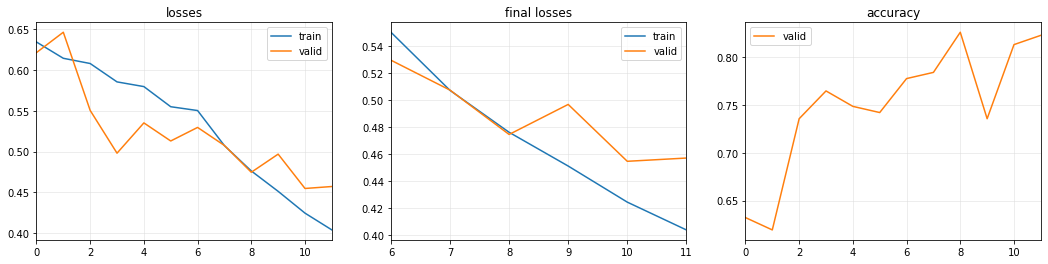

premature ventricular beat F1 score == 0.7534


'Iteration    1'

epoch,train_loss,valid_loss,accuracy,time
0,0.413557,0.475758,0.800000,00:03
1,0.443653,0.525225,0.741935,00:03
2,0.498459,0.532396,0.741935,00:03
3,0.497979,0.523763,0.735484,00:03
4,0.483244,0.540693,0.764516,00:03
5,0.453322,0.503929,0.787097,00:03
6,0.453403,0.524332,0.706452,00:03
7,0.435963,0.463010,0.812903,00:03
8,0.397133,0.430555,0.883871,00:03
9,0.367485,0.404576,0.838710,00:03


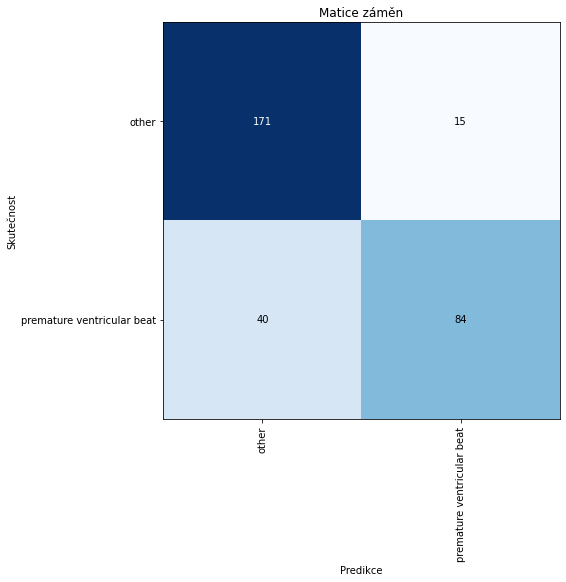

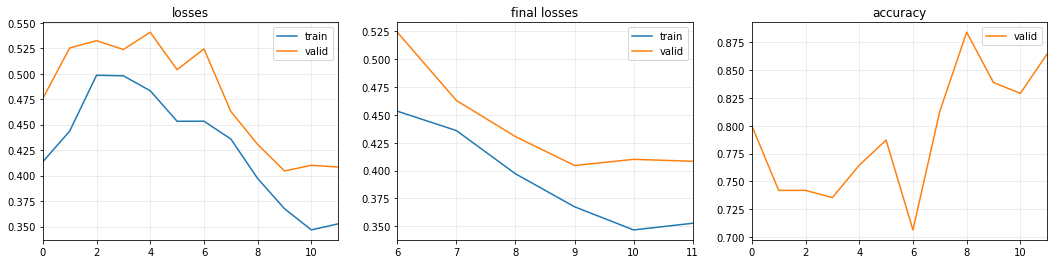

premature ventricular beat F1 score == 0.832


'Iteration    2'

epoch,train_loss,valid_loss,accuracy,time
0,0.324443,0.397751,0.861290,00:03
1,0.370521,0.371472,0.867742,00:03
2,0.417951,0.475542,0.748387,00:03
3,0.428893,0.502223,0.822581,00:03
4,0.416753,0.488048,0.777419,00:03
5,0.418954,0.511889,0.732258,00:03
6,0.384307,0.521551,0.754839,00:03
7,0.354785,0.458531,0.767742,00:03
8,0.337696,0.474453,0.783871,00:03
9,0.315960,0.380548,0.864516,00:03


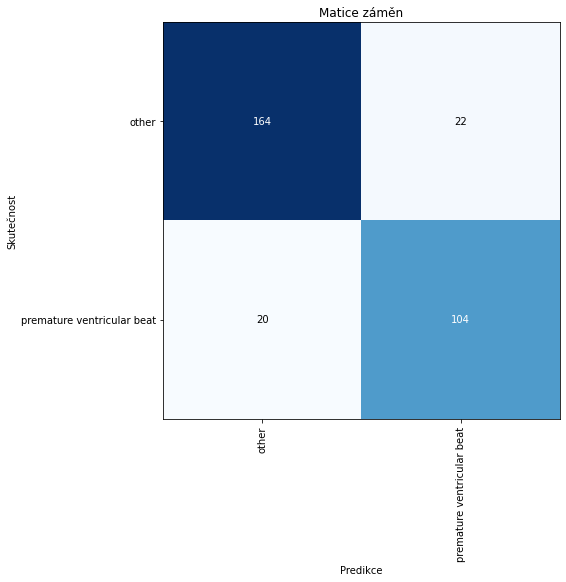

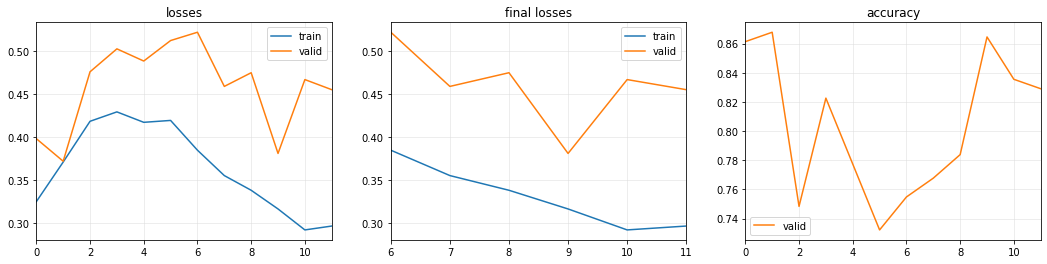

premature ventricular beat F1 score == 0.7512


'Iteration    3'

epoch,train_loss,valid_loss,accuracy,time
0,0.267600,0.440468,0.835484,00:03
1,0.313953,0.596394,0.741935,00:03
2,0.372833,0.431164,0.822581,00:03
3,0.378668,0.492530,0.819355,00:03
4,0.342578,0.411564,0.845161,00:03
5,0.384690,0.582626,0.864516,00:03
6,0.360563,0.420622,0.848387,00:03
7,0.322971,0.370037,0.848387,00:03
8,0.289814,0.436523,0.816129,00:03
9,0.285288,0.438460,0.809677,00:03


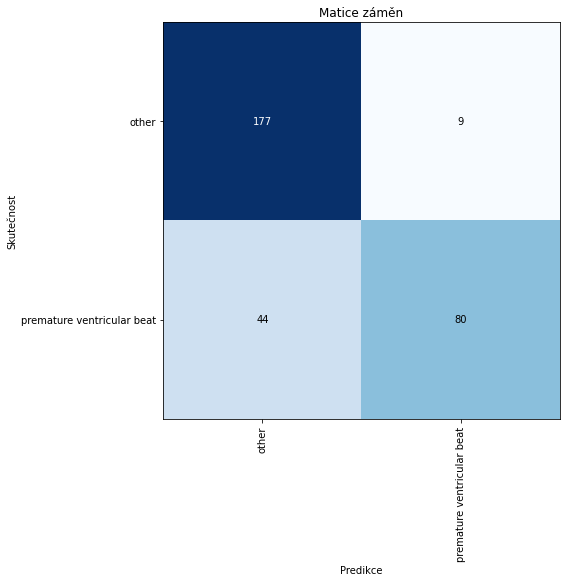

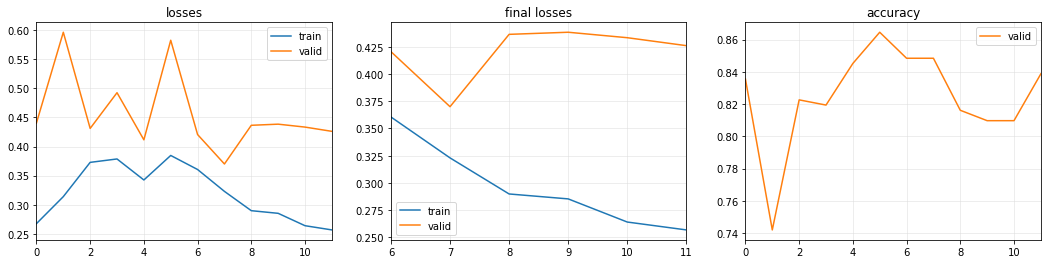

premature ventricular beat F1 score == 0.7664


'Iteration    4'

epoch,train_loss,valid_loss,accuracy,time
0,0.252154,0.432509,0.858065,00:03
1,0.266186,0.563505,0.719355,00:03
2,0.328394,0.385203,0.861290,00:03
3,0.357369,0.561625,0.796774,00:03
4,0.342417,0.472024,0.754839,00:03
5,0.328592,0.504368,0.803226,00:03
6,0.306320,0.417600,0.854839,00:03
7,0.262704,0.428089,0.800000,00:03
8,0.251150,0.436763,0.806452,00:03
9,0.244612,0.400519,0.845161,00:03


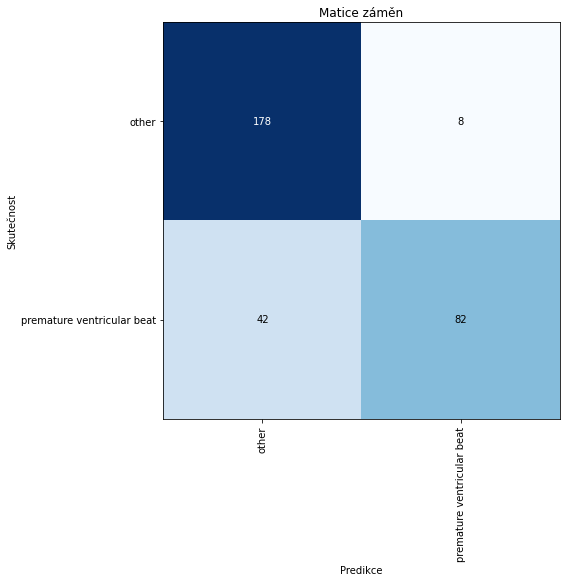

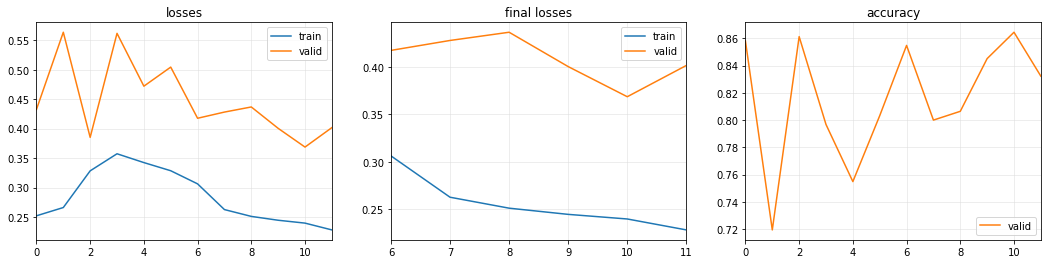

premature ventricular beat F1 score == 0.7547


'Iteration    5'

epoch,train_loss,valid_loss,accuracy,time
0,0.219238,0.409187,0.838710,00:03
1,0.248165,0.505673,0.735484,00:03
2,0.294346,0.554233,0.725806,00:03
3,0.303131,0.560593,0.751613,00:03
4,0.307841,0.649357,0.683871,00:03
5,0.307909,0.425954,0.796774,00:03
6,0.266256,0.517076,0.751613,00:03
7,0.255985,0.458603,0.770968,00:03
8,0.261527,0.406314,0.825806,00:03
9,0.229597,0.342304,0.874194,00:03


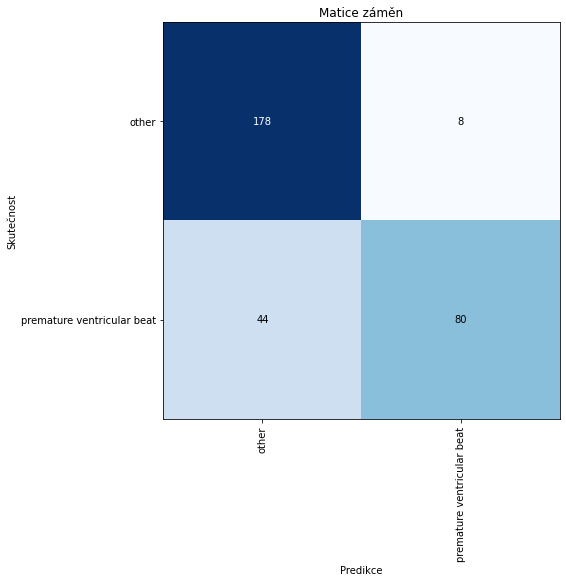

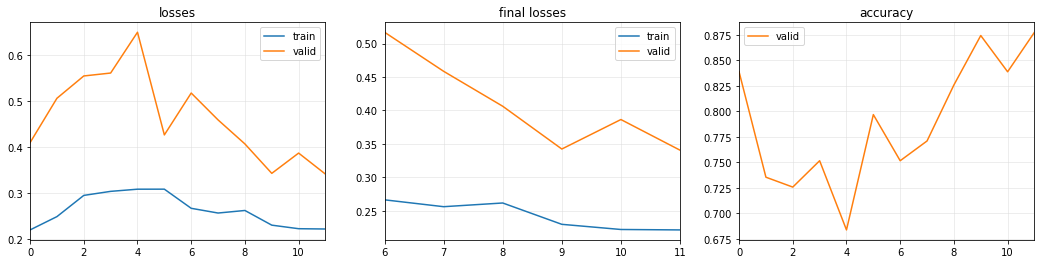

premature ventricular beat F1 score == 0.8288


'Iteration    6'

epoch,train_loss,valid_loss,accuracy,time
0,0.209116,0.408895,0.825806,00:03
1,0.250167,0.537724,0.829032,00:03
2,0.314274,0.688138,0.858065,00:03
3,0.296480,0.518472,0.829032,00:03
4,0.296316,0.337286,0.877419,00:03
5,0.272120,0.610720,0.777419,00:03
6,0.250976,0.437456,0.822581,00:03
7,0.251693,0.452805,0.812903,00:03
8,0.226889,0.348825,0.845161,00:03
9,0.221763,0.371327,0.809677,00:03


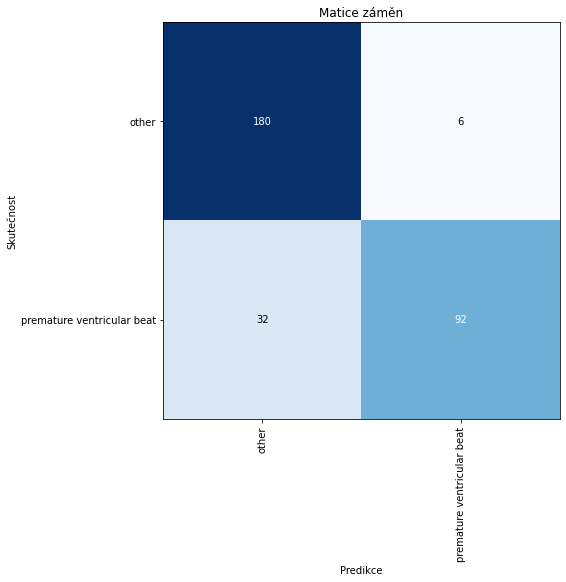

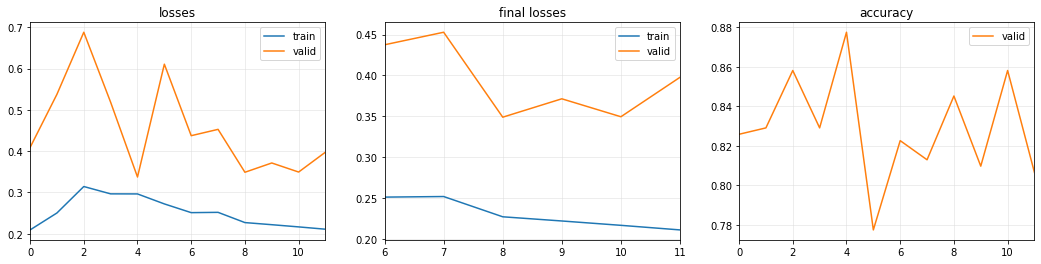

premature ventricular beat F1 score == 0.6939


'Iteration    7'

epoch,train_loss,valid_loss,accuracy,time
0,0.207771,0.361657,0.838710,00:03
1,0.207117,0.517078,0.761290,00:03
2,0.279705,0.632112,0.729032,00:03
3,0.286151,0.436552,0.819355,00:03
4,0.277290,0.404052,0.883871,00:03
5,0.243778,0.426921,0.835484,00:03
6,0.226799,0.448389,0.803226,00:03
7,0.231692,0.408005,0.841935,00:03
8,0.228436,0.412358,0.832258,00:03
9,0.213866,0.534202,0.706452,00:03


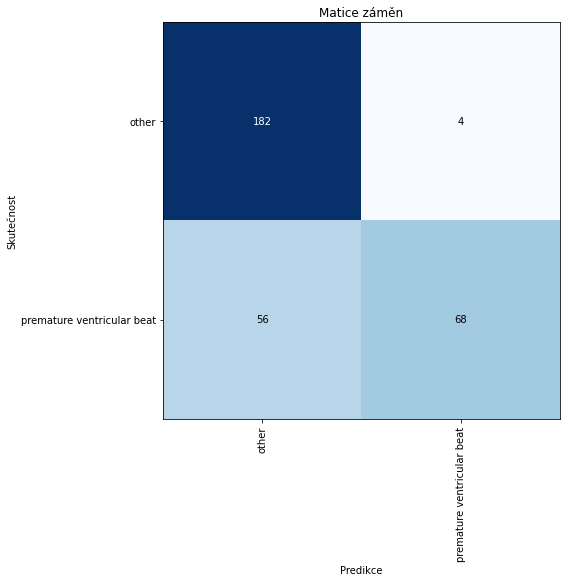

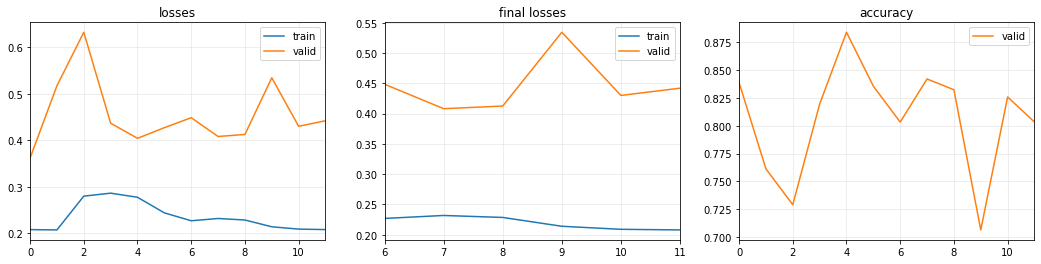

premature ventricular beat F1 score == 0.6904


'Iteration    8'

epoch,train_loss,valid_loss,accuracy,time
0,0.196349,0.424013,0.819355,00:03
1,0.202656,0.498931,0.774194,00:03
2,0.236824,0.763808,0.777419,00:03
3,0.255310,0.359941,0.858065,00:03
4,0.261394,0.775394,0.758065,00:03


KeyboardInterrupt: ignored

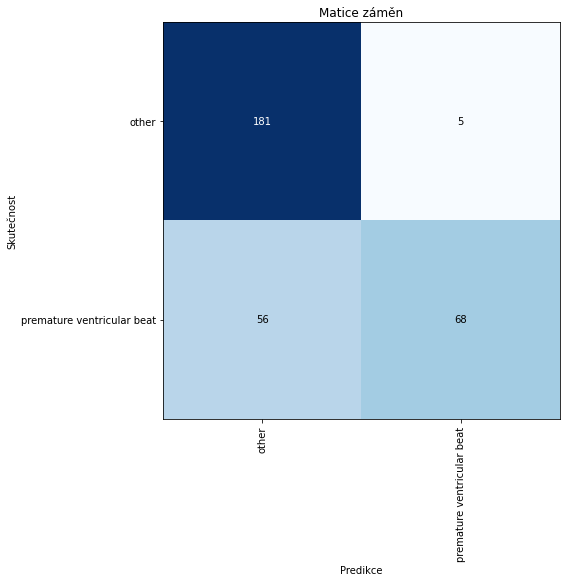

In [ ]:
y_to_use_search_space = {
    'binary': ['premature ventricular beat',],
#     'ternary': ['premature ventricular beat', 'sinus rhythm'],
#     'reasonable': [
#         'sinus rhythm', 
#         'noisy ECG', 
#         'tachycardia', 
#         'myocardial infarction',
#         'bradycardia', 
#         'STT changes', 
#         'atrial fibrillation', 
#         'premature atrial beat',
#         'premature ventricular beat',   # Of interest
#           ],
}

y_labels_ = ['premature ventricular beat']
for output_name_, y_to_use_ in y_to_use_search_space.items():
    df = perform_hyper_search(y_to_use_, y_labels_)
    df.to_csv(data_folder / f'{output_name_}.csv', index=False)

In [ ]:
best_hyper = {'bs_': 18.45702114214058,
 'cycle_len_': 7.439603784503289,
 'max_duplicate_': 3.12327443248267,
 'max_extra_': 3.1219158581093835,
 'mixup_alpha_': 0.31335505476578823,
 'num_of_cycles_': 15.02712020169596,
#  'f1': 0.8307692307692308
}

generate_eval_hyperparams(Y_TO_DROP_)(**best_hyper)